In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from utils import plot_learning_curve

In [2]:
class TwoInputsNet(nn.Module):
    # ****
    # tengo que revisar mejor sobre los channels y toda esta locura porque hay algo raro. sobretodo en la parte de los filtros.
    
    # revisa que todas tus dimensiones esten correctas.
    # ****
    def __init__(self, lr, in_channels, out_channels, kernel_size, input_dims, fc1_dims, fc2_dims, n_actions):
        super(TwoInputsNet, self).__init__()
        self.conv_open = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_high = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_low = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_close = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_volume = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.fc_state = nn.Linear(2, 2)
        
        self.fc1 = nn.Linear(input_dims, fc1_dims) #input dims is the sum of all outputs of the conv layers.
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        # Open High Low Close Volume in that order (also for the numpy array)
        # input6 son dos nodos de input para saber si el agente ha comprado/vendido y en cuanto.
    def forward(self, input1, input2, input3, input4, input5, input6):
        c1 = self.conv_open(input1.unsqueeze(dim = 1))
        c2 = self.conv_high(input2.unsqueeze(dim = 1))
        c3 = self.conv_low(input3.unsqueeze(dim = 1))
        c4 = self.conv_close(input4.unsqueeze(dim = 1))
        c5 = self.conv_volume(input5.unsqueeze(dim = 1))
        f1 = self.fc_state(input6)
        
        # now we can reshape to 2D and concat them
        combined = T.cat((c1.view(c1.size(0), -1), 
                          c2.view(c2.size(0), -1),
                          c3.view(c3.size(0), -1),
                          c4.view(c4.size(0), -1),
                          c5.view(c5.size(0), -1),
                          f1.view(f1.size(0), -1)), dim=1)
        
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions
    
class Agent():
    # ***hyperparameters
    def __init__(self, gamma, epsilon, lr, input_dims1, input_dims2, batch_size, n_actions,
                max_mem_size = 100000, eps_end=0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        # self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        # (self, lr, in_channels, out_channels, kernel_size, input_dims, fc1_dims, fc2_dims, n_actions)
        # en otras parabras (learning rate, cantidad de filtros de entrada, cantidad de filtros de salida, tamaño del kernel)
        #  ***hyperparameters
        self.Q_eval = TwoInputsNet(self.lr, 1, 4, 3, 562, 128, 128, n_actions)
        #                                             ^
        # tengo que encontrar una forma para hacer que se haga el tamaño del fc layer automaticamente
        
        # ***
        # tengo que reviar si el replay memory esta funcionando correctamente, sobre todo el *input_dims
        # as of now I checked the state_memory shape (10000, 30, 5) and it looks correct
        # ***
        self.state_memory = np.zeros((self.mem_size, *input_dims1), dtype = np.float32)
        self.state_memory2 = np.zeros((self.mem_size, *input_dims2), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims1), dtype=np.float32)
        self.new_state_memory2 = np.zeros((self.mem_size, *input_dims2), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state[0]
        self.state_memory2[index] = state[1]
        self.new_state_memory[index] = state_[0]
        self.new_state_memory2[index] = state_[1]
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # aqui tuve que separar la observacion en las 2 partes y transformarlas a pytorch tensor. 
            # no se si es lo mejor, pero sirve asi que...
            
            state = T.tensor([observation[0]]).to(self.Q_eval.device)
            state2 = T.tensor([observation[1]]).to(self.Q_eval.device)
#             print(state)
            actions = self.Q_eval.forward(state[:,:,0], 
                                          state[:,:,1], 
                                          state[:,:,2], 
                                          state[:,:,3], 
                                          state[:,:,4],
                                          state2[:])
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        state_batch2 = T.tensor(self.state_memory2[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        new_state_batch2 = T.tensor(self.new_state_memory2[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch[:,:,0],
                                     state_batch[:,:,1],
                                     state_batch[:,:,2],
                                     state_batch[:,:,3],
                                     state_batch[:,:,4],
                                     state_batch2[:])[batch_index, action_batch]
    
        q_next = self.Q_eval.forward(new_state_batch[:,:,0],
                                     new_state_batch[:,:,1],
                                     new_state_batch[:,:,2],
                                     new_state_batch[:,:,3],
                                     new_state_batch[:,:,4],
                                     new_state_batch2[:])
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                        else self.eps_min


The episode ran for 4 timesteps.
episode 0 score -0.04 average score -0.04 sum score -0.04 epsilon 1.00
The episode ran for 5 timesteps.
episode 1 score 0.02 average score -0.01 sum score -0.02 epsilon 1.00
The episode ran for 5 timesteps.
episode 2 score 0.01 average score -0.00 sum score -0.01 epsilon 1.00
The episode ran for 5 timesteps.
episode 3 score 0.00 average score -0.00 sum score -0.01 epsilon 1.00
The episode ran for 9 timesteps.
episode 4 score 0.01 average score 0.00 sum score 0.00 epsilon 1.00
The episode ran for 4 timesteps.
episode 5 score -0.05 average score -0.01 sum score -0.05 epsilon 1.00
The episode ran for 4 timesteps.
episode 6 score -0.02 average score -0.01 sum score -0.07 epsilon 1.00
The episode ran for 4 timesteps.
episode 7 score 0.00 average score -0.01 sum score -0.07 epsilon 1.00
The episode ran for 2 timesteps.
episode 8 score 0.01 average score -0.01 sum score -0.06 epsilon 1.00
The episode ran for 3 timesteps.
episode 9 score -0.00 average score -0.

episode 82 score -0.00 average score 0.00 sum score 0.21 epsilon 0.83
The episode ran for 6 timesteps.
episode 83 score 0.00 average score 0.00 sum score 0.21 epsilon 0.82
The episode ran for 8 timesteps.
episode 84 score -0.01 average score 0.00 sum score 0.20 epsilon 0.82
The episode ran for 6 timesteps.
episode 85 score -0.00 average score 0.00 sum score 0.20 epsilon 0.82
The episode ran for 6 timesteps.
episode 86 score -0.01 average score 0.00 sum score 0.19 epsilon 0.81
The episode ran for 5 timesteps.
episode 87 score -0.01 average score 0.00 sum score 0.19 epsilon 0.81
The episode ran for 2 timesteps.
episode 88 score -0.00 average score 0.00 sum score 0.19 epsilon 0.81
The episode ran for 8 timesteps.
episode 89 score 0.08 average score 0.00 sum score 0.26 epsilon 0.80
The episode ran for 6 timesteps.
episode 90 score 0.00 average score 0.00 sum score 0.27 epsilon 0.80
The episode ran for 3 timesteps.
episode 91 score -0.02 average score 0.00 sum score 0.25 epsilon 0.80
The ep

episode 163 score 0.00 average score 0.00 sum score 0.45 epsilon 0.61
The episode ran for 4 timesteps.
episode 164 score -0.00 average score 0.00 sum score 0.45 epsilon 0.61
The episode ran for 5 timesteps.
episode 165 score -0.01 average score 0.00 sum score 0.44 epsilon 0.61
The episode ran for 2 timesteps.
episode 166 score 0.00 average score 0.00 sum score 0.44 epsilon 0.61
The episode ran for 5 timesteps.
episode 167 score -0.00 average score 0.00 sum score 0.44 epsilon 0.61
The episode ran for 2 timesteps.
episode 168 score 0.01 average score 0.00 sum score 0.45 epsilon 0.61
The episode ran for 8 timesteps.
episode 169 score -0.00 average score 0.00 sum score 0.44 epsilon 0.60
The episode ran for 4 timesteps.
episode 170 score -0.02 average score 0.00 sum score 0.42 epsilon 0.60
The episode ran for 4 timesteps.
episode 171 score 0.01 average score 0.00 sum score 0.44 epsilon 0.60
The episode ran for 4 timesteps.
episode 172 score -0.00 average score 0.00 sum score 0.43 epsilon 0.

The episode ran for 3 timesteps.
episode 244 score 0.01 average score 0.00 sum score 0.06 epsilon 0.41
The episode ran for 4 timesteps.
episode 245 score 0.04 average score 0.00 sum score 0.10 epsilon 0.41
The episode ran for 2 timesteps.
episode 246 score -0.00 average score 0.00 sum score 0.10 epsilon 0.40
The episode ran for 10 timesteps.
episode 247 score 0.08 average score 0.00 sum score 0.18 epsilon 0.40
The episode ran for 7 timesteps.
episode 248 score 0.03 average score 0.00 sum score 0.21 epsilon 0.40
The episode ran for 6 timesteps.
episode 249 score 0.01 average score 0.00 sum score 0.22 epsilon 0.39
The episode ran for 2 timesteps.
episode 250 score 0.00 average score 0.00 sum score 0.22 epsilon 0.39
The episode ran for 4 timesteps.
episode 251 score -0.01 average score 0.00 sum score 0.21 epsilon 0.39
The episode ran for 8 timesteps.
episode 252 score -0.01 average score 0.00 sum score 0.20 epsilon 0.39
The episode ran for 3 timesteps.
episode 253 score -0.01 average scor

The episode ran for 4 timesteps.
episode 324 score 0.04 average score 0.00 sum score 0.01 epsilon 0.20
The episode ran for 5 timesteps.
episode 325 score -0.01 average score 0.00 sum score 0.00 epsilon 0.20
The episode ran for 10 timesteps.
episode 326 score 0.04 average score 0.00 sum score 0.04 epsilon 0.19
The episode ran for 6 timesteps.
episode 327 score -0.03 average score 0.00 sum score 0.01 epsilon 0.19
The episode ran for 5 timesteps.
episode 328 score -0.00 average score 0.00 sum score 0.01 epsilon 0.19
The episode ran for 19 timesteps.
episode 329 score -0.12 average score -0.00 sum score -0.11 epsilon 0.18
The episode ran for 5 timesteps.
episode 330 score -0.02 average score -0.00 sum score -0.13 epsilon 0.18
The episode ran for 10 timesteps.
episode 331 score 0.05 average score -0.00 sum score -0.08 epsilon 0.17
The episode ran for 5 timesteps.
episode 332 score -0.01 average score -0.00 sum score -0.09 epsilon 0.17
The episode ran for 5 timesteps.
episode 333 score -0.02

The episode ran for 4 timesteps.
episode 404 score -0.00 average score 0.00 sum score 0.64 epsilon 0.01
The episode ran for 7 timesteps.
episode 405 score -0.00 average score 0.00 sum score 0.64 epsilon 0.01
The episode ran for 8 timesteps.
episode 406 score -0.08 average score 0.00 sum score 0.56 epsilon 0.01
The episode ran for 8 timesteps.
episode 407 score 0.07 average score 0.00 sum score 0.64 epsilon 0.01
The episode ran for 8 timesteps.
episode 408 score 0.01 average score 0.00 sum score 0.65 epsilon 0.01
The episode ran for 11 timesteps.
episode 409 score -0.01 average score 0.00 sum score 0.64 epsilon 0.01
The episode ran for 3 timesteps.
episode 410 score -0.00 average score 0.00 sum score 0.64 epsilon 0.01
The episode ran for 19 timesteps.
episode 411 score -0.13 average score 0.00 sum score 0.51 epsilon 0.01
The episode ran for 8 timesteps.
episode 412 score -0.00 average score 0.00 sum score 0.51 epsilon 0.01
The episode ran for 3 timesteps.
episode 413 score -0.03 average

The episode ran for 7 timesteps.
episode 483 score -0.01 average score 0.00 sum score 0.59 epsilon 0.01
The episode ran for 2 timesteps.
episode 484 score 0.01 average score 0.00 sum score 0.60 epsilon 0.01
The episode ran for 2 timesteps.
episode 485 score -0.00 average score 0.00 sum score 0.59 epsilon 0.01
The episode ran for 8 timesteps.
episode 486 score -0.01 average score 0.00 sum score 0.58 epsilon 0.01
The episode ran for 4 timesteps.
episode 487 score 0.00 average score 0.00 sum score 0.59 epsilon 0.01
The episode ran for 7 timesteps.
episode 488 score -0.00 average score 0.00 sum score 0.58 epsilon 0.01
The episode ran for 6 timesteps.
episode 489 score 0.01 average score 0.00 sum score 0.59 epsilon 0.01
The episode ran for 4 timesteps.
episode 490 score 0.00 average score 0.00 sum score 0.59 epsilon 0.01
The episode ran for 6 timesteps.
episode 491 score 0.02 average score 0.00 sum score 0.61 epsilon 0.01
The episode ran for 6 timesteps.
episode 492 score 0.01 average score

The episode ran for 17 timesteps.
episode 562 score 0.05 average score 0.00 sum score 1.18 epsilon 0.01
The episode ran for 5 timesteps.
episode 563 score 0.02 average score 0.00 sum score 1.20 epsilon 0.01
The episode ran for 14 timesteps.
episode 564 score 0.04 average score 0.00 sum score 1.24 epsilon 0.01
The episode ran for 9 timesteps.
episode 565 score -0.05 average score 0.00 sum score 1.19 epsilon 0.01
The episode ran for 6 timesteps.
episode 566 score -0.05 average score 0.00 sum score 1.14 epsilon 0.01
The episode ran for 22 timesteps.
episode 567 score -0.02 average score 0.00 sum score 1.12 epsilon 0.01
The episode ran for 3 timesteps.
episode 568 score 0.00 average score 0.00 sum score 1.13 epsilon 0.01
The episode ran for 13 timesteps.
episode 569 score 0.08 average score 0.00 sum score 1.20 epsilon 0.01
The episode ran for 21 timesteps.
episode 570 score -0.10 average score 0.00 sum score 1.10 epsilon 0.01
The episode ran for 12 timesteps.
episode 571 score -0.02 averag

The episode ran for 14 timesteps.
episode 641 score -0.00 average score 0.00 sum score 1.60 epsilon 0.01
The episode ran for 12 timesteps.
episode 642 score -0.02 average score 0.00 sum score 1.58 epsilon 0.01
The episode ran for 2 timesteps.
episode 643 score 0.00 average score 0.00 sum score 1.58 epsilon 0.01
The episode ran for 11 timesteps.
episode 644 score 0.00 average score 0.00 sum score 1.58 epsilon 0.01
The episode ran for 28 timesteps.
episode 645 score -0.02 average score 0.00 sum score 1.57 epsilon 0.01
The episode ran for 8 timesteps.
episode 646 score 0.19 average score 0.00 sum score 1.76 epsilon 0.01
The episode ran for 7 timesteps.
episode 647 score -0.02 average score 0.00 sum score 1.73 epsilon 0.01
The episode ran for 4 timesteps.
episode 648 score 0.00 average score 0.00 sum score 1.74 epsilon 0.01
The episode ran for 3 timesteps.
episode 649 score -0.00 average score 0.00 sum score 1.74 epsilon 0.01
The episode ran for 4 timesteps.
episode 650 score 0.03 average 

The episode ran for 5 timesteps.
episode 720 score 0.02 average score 0.00 sum score 2.75 epsilon 0.01
The episode ran for 8 timesteps.
episode 721 score 0.09 average score 0.00 sum score 2.84 epsilon 0.01
The episode ran for 6 timesteps.
episode 722 score 0.10 average score 0.00 sum score 2.94 epsilon 0.01
The episode ran for 15 timesteps.
episode 723 score -0.06 average score 0.00 sum score 2.88 epsilon 0.01
The episode ran for 4 timesteps.
episode 724 score -0.00 average score 0.00 sum score 2.88 epsilon 0.01
The episode ran for 2 timesteps.
episode 725 score 0.00 average score 0.00 sum score 2.88 epsilon 0.01
The episode ran for 3 timesteps.
episode 726 score 0.01 average score 0.00 sum score 2.89 epsilon 0.01
The episode ran for 10 timesteps.
episode 727 score 0.00 average score 0.00 sum score 2.89 epsilon 0.01
The episode ran for 42 timesteps.
episode 728 score -0.08 average score 0.00 sum score 2.81 epsilon 0.01
The episode ran for 11 timesteps.
episode 729 score -0.09 average s

The episode ran for 18 timesteps.
episode 799 score -0.01 average score 0.00 sum score 3.09 epsilon 0.01
The episode ran for 27 timesteps.
episode 800 score -0.01 average score 0.00 sum score 3.08 epsilon 0.01
The episode ran for 3 timesteps.
episode 801 score 0.01 average score 0.00 sum score 3.09 epsilon 0.01
The episode ran for 7 timesteps.
episode 802 score 0.05 average score 0.00 sum score 3.14 epsilon 0.01
The episode ran for 33 timesteps.
episode 803 score 0.11 average score 0.00 sum score 3.25 epsilon 0.01
The episode ran for 4 timesteps.
episode 804 score 0.01 average score 0.00 sum score 3.26 epsilon 0.01
The episode ran for 8 timesteps.
episode 805 score 0.00 average score 0.00 sum score 3.26 epsilon 0.01
The episode ran for 9 timesteps.
episode 806 score -0.07 average score 0.00 sum score 3.19 epsilon 0.01
The episode ran for 3 timesteps.
episode 807 score 0.02 average score 0.00 sum score 3.20 epsilon 0.01
The episode ran for 2 timesteps.
episode 808 score 0.00 average sco

The episode ran for 118 timesteps.
episode 878 score -0.77 average score 0.10 sum score 88.07 epsilon 0.01
The episode ran for 57 timesteps.
episode 879 score 0.95 average score 0.10 sum score 89.02 epsilon 0.01
The episode ran for 96 timesteps.
episode 880 score 0.52 average score 0.10 sum score 89.54 epsilon 0.01
The episode ran for 202 timesteps.
episode 881 score 17.04 average score 0.12 sum score 106.58 epsilon 0.01
The episode ran for 206 timesteps.
episode 882 score 7.28 average score 0.13 sum score 113.86 epsilon 0.01
The episode ran for 197 timesteps.
episode 883 score -7.20 average score 0.12 sum score 106.66 epsilon 0.01
The episode ran for 201 timesteps.
episode 884 score 5.40 average score 0.13 sum score 112.06 epsilon 0.01
The episode ran for 92 timesteps.
episode 885 score 2.17 average score 0.13 sum score 114.24 epsilon 0.01
The episode ran for 299 timesteps.
episode 886 score -26.34 average score 0.10 sum score 87.89 epsilon 0.01
The episode ran for 81 timesteps.
episo

The episode ran for 645 timesteps.
episode 956 score 0.13 average score 0.08 sum score 81.01 epsilon 0.01
The episode ran for 38 timesteps.
episode 957 score -0.02 average score 0.08 sum score 80.99 epsilon 0.01
The episode ran for 519 timesteps.
episode 958 score 0.07 average score 0.08 sum score 81.06 epsilon 0.01
The episode ran for 487 timesteps.
episode 959 score 18.74 average score 0.10 sum score 99.79 epsilon 0.01
The episode ran for 88 timesteps.
episode 960 score 0.00 average score 0.10 sum score 99.79 epsilon 0.01
The episode ran for 67 timesteps.
episode 961 score 0.01 average score 0.10 sum score 99.80 epsilon 0.01
The episode ran for 148 timesteps.
episode 962 score -4.28 average score 0.10 sum score 95.52 epsilon 0.01
The episode ran for 34 timesteps.
episode 963 score -0.32 average score 0.10 sum score 95.20 epsilon 0.01
The episode ran for 99 timesteps.
episode 964 score -0.78 average score 0.10 sum score 94.42 epsilon 0.01
The episode ran for 202 timesteps.
episode 965

The episode ran for 5 timesteps.
episode 38 score -0.01 average score 0.01 sum score 0.23 epsilon 0.95
The episode ran for 3 timesteps.
episode 39 score 0.01 average score 0.01 sum score 0.23 epsilon 0.95
The episode ran for 5 timesteps.
episode 40 score 0.01 average score 0.01 sum score 0.24 epsilon 0.95
The episode ran for 11 timesteps.
episode 41 score -0.02 average score 0.01 sum score 0.22 epsilon 0.94
The episode ran for 5 timesteps.
episode 42 score -0.00 average score 0.01 sum score 0.22 epsilon 0.94
The episode ran for 4 timesteps.
episode 43 score -0.02 average score 0.00 sum score 0.20 epsilon 0.94
The episode ran for 2 timesteps.
episode 44 score 0.00 average score 0.00 sum score 0.20 epsilon 0.94
The episode ran for 3 timesteps.
episode 45 score 0.00 average score 0.00 sum score 0.21 epsilon 0.93
The episode ran for 12 timesteps.
episode 46 score 0.04 average score 0.01 sum score 0.24 epsilon 0.93
The episode ran for 3 timesteps.
episode 47 score -0.01 average score 0.00 s

The episode ran for 11 timesteps.
episode 118 score 0.07 average score 0.01 sum score 0.69 epsilon 0.74
The episode ran for 8 timesteps.
episode 119 score 0.03 average score 0.01 sum score 0.71 epsilon 0.74
The episode ran for 2 timesteps.
episode 120 score -0.00 average score 0.01 sum score 0.71 epsilon 0.74
The episode ran for 2 timesteps.
episode 121 score 0.00 average score 0.01 sum score 0.72 epsilon 0.74
The episode ran for 3 timesteps.
episode 122 score 0.00 average score 0.01 sum score 0.72 epsilon 0.73
The episode ran for 9 timesteps.
episode 123 score 0.21 average score 0.01 sum score 0.93 epsilon 0.73
The episode ran for 9 timesteps.
episode 124 score 0.04 average score 0.01 sum score 0.96 epsilon 0.73
The episode ran for 8 timesteps.
episode 125 score -0.04 average score 0.01 sum score 0.92 epsilon 0.72
The episode ran for 7 timesteps.
episode 126 score 0.02 average score 0.01 sum score 0.94 epsilon 0.72
The episode ran for 6 timesteps.
episode 127 score 0.05 average score 

The episode ran for 4 timesteps.
episode 201 score 0.02 average score 0.01 sum score 1.60 epsilon 0.52
The episode ran for 2 timesteps.
episode 202 score 0.00 average score 0.01 sum score 1.61 epsilon 0.52
The episode ran for 4 timesteps.
episode 203 score 0.01 average score 0.01 sum score 1.62 epsilon 0.52
The episode ran for 4 timesteps.
episode 204 score -0.01 average score 0.01 sum score 1.61 epsilon 0.52
The episode ran for 6 timesteps.
episode 205 score 0.02 average score 0.01 sum score 1.63 epsilon 0.52
The episode ran for 2 timesteps.
episode 206 score 0.00 average score 0.01 sum score 1.63 epsilon 0.51
The episode ran for 9 timesteps.
episode 207 score -0.01 average score 0.01 sum score 1.62 epsilon 0.51
The episode ran for 2 timesteps.
episode 208 score -0.01 average score 0.01 sum score 1.62 epsilon 0.51
The episode ran for 2 timesteps.
episode 209 score -0.01 average score 0.01 sum score 1.61 epsilon 0.51
The episode ran for 6 timesteps.
episode 210 score 0.00 average score

The episode ran for 12 timesteps.
episode 280 score 0.00 average score 0.00 sum score 1.31 epsilon 0.31
The episode ran for 13 timesteps.
episode 281 score 0.01 average score 0.00 sum score 1.31 epsilon 0.31
The episode ran for 8 timesteps.
episode 282 score 0.00 average score 0.00 sum score 1.32 epsilon 0.30
The episode ran for 8 timesteps.
episode 283 score -0.05 average score 0.00 sum score 1.27 epsilon 0.30
The episode ran for 14 timesteps.
episode 284 score 0.00 average score 0.00 sum score 1.27 epsilon 0.29
The episode ran for 12 timesteps.
episode 285 score -0.05 average score 0.00 sum score 1.22 epsilon 0.29
The episode ran for 8 timesteps.
episode 286 score -0.02 average score 0.00 sum score 1.20 epsilon 0.28
The episode ran for 4 timesteps.
episode 287 score 0.02 average score 0.00 sum score 1.22 epsilon 0.28
The episode ran for 4 timesteps.
episode 288 score 0.01 average score 0.00 sum score 1.22 epsilon 0.28
The episode ran for 6 timesteps.
episode 289 score -0.04 average s

The episode ran for 47 timesteps.
episode 360 score 0.25 average score 0.01 sum score 3.70 epsilon 0.01
The episode ran for 17 timesteps.
episode 361 score -0.01 average score 0.01 sum score 3.69 epsilon 0.01
The episode ran for 8 timesteps.
episode 362 score -0.01 average score 0.01 sum score 3.68 epsilon 0.01
The episode ran for 13 timesteps.
episode 363 score -0.05 average score 0.01 sum score 3.63 epsilon 0.01
The episode ran for 10 timesteps.
episode 364 score -0.02 average score 0.01 sum score 3.61 epsilon 0.01
The episode ran for 71 timesteps.
episode 365 score 4.64 average score 0.02 sum score 8.24 epsilon 0.01
The episode ran for 34 timesteps.
episode 366 score -0.32 average score 0.02 sum score 7.93 epsilon 0.01
The episode ran for 18 timesteps.
episode 367 score 0.62 average score 0.02 sum score 8.55 epsilon 0.01
The episode ran for 13 timesteps.
episode 368 score 0.00 average score 0.02 sum score 8.55 epsilon 0.01
The episode ran for 4 timesteps.
episode 369 score 0.01 aver

The episode ran for 88 timesteps.
episode 439 score 3.02 average score 0.01 sum score 5.06 epsilon 0.01
The episode ran for 8 timesteps.
episode 440 score -0.05 average score 0.01 sum score 5.01 epsilon 0.01
The episode ran for 2 timesteps.
episode 441 score 0.01 average score 0.01 sum score 5.01 epsilon 0.01
The episode ran for 50 timesteps.
episode 442 score 0.96 average score 0.01 sum score 5.97 epsilon 0.01
The episode ran for 22 timesteps.
episode 443 score 0.13 average score 0.01 sum score 6.10 epsilon 0.01
The episode ran for 37 timesteps.
episode 444 score -0.27 average score 0.01 sum score 5.82 epsilon 0.01
The episode ran for 59 timesteps.
episode 445 score -1.53 average score 0.01 sum score 4.30 epsilon 0.01
The episode ran for 2 timesteps.
episode 446 score -0.00 average score 0.01 sum score 4.30 epsilon 0.01
The episode ran for 61 timesteps.
episode 447 score -0.98 average score 0.01 sum score 3.31 epsilon 0.01
The episode ran for 2 timesteps.
episode 448 score 0.00 averag

The episode ran for 147 timesteps.
episode 518 score -3.01 average score 0.04 sum score 19.00 epsilon 0.01
The episode ran for 56 timesteps.
episode 519 score -1.30 average score 0.03 sum score 17.70 epsilon 0.01
The episode ran for 383 timesteps.
episode 520 score 17.18 average score 0.07 sum score 34.88 epsilon 0.01
The episode ran for 34 timesteps.
episode 521 score -0.52 average score 0.07 sum score 34.36 epsilon 0.01
The episode ran for 91 timesteps.
episode 522 score 2.03 average score 0.07 sum score 36.40 epsilon 0.01
The episode ran for 4 timesteps.
episode 523 score 0.07 average score 0.07 sum score 36.47 epsilon 0.01
The episode ran for 3 timesteps.
episode 524 score -0.01 average score 0.07 sum score 36.46 epsilon 0.01
The episode ran for 36 timesteps.
episode 525 score 0.10 average score 0.07 sum score 36.56 epsilon 0.01
The episode ran for 30 timesteps.
episode 526 score -0.07 average score 0.07 sum score 36.49 epsilon 0.01
The episode ran for 24 timesteps.
episode 527 sco

The episode ran for 121 timesteps.
episode 596 score -0.17 average score 0.02 sum score 12.56 epsilon 0.01
The episode ran for 43 timesteps.
episode 597 score -0.60 average score 0.02 sum score 11.95 epsilon 0.01
The episode ran for 123 timesteps.
episode 598 score -0.59 average score 0.02 sum score 11.36 epsilon 0.01
The episode ran for 53 timesteps.
episode 599 score -0.04 average score 0.02 sum score 11.32 epsilon 0.01
The episode ran for 123 timesteps.
episode 600 score -3.47 average score 0.01 sum score 7.84 epsilon 0.01
The episode ran for 115 timesteps.
episode 601 score 9.56 average score 0.03 sum score 17.41 epsilon 0.01
The episode ran for 78 timesteps.
episode 602 score 0.33 average score 0.03 sum score 17.73 epsilon 0.01
The episode ran for 32 timesteps.
episode 603 score -0.28 average score 0.03 sum score 17.45 epsilon 0.01
The episode ran for 23 timesteps.
episode 604 score -0.30 average score 0.03 sum score 17.15 epsilon 0.01
The episode ran for 61 timesteps.
episode 605

The episode ran for 168 timesteps.
episode 674 score -1.10 average score 0.04 sum score 26.60 epsilon 0.01
The episode ran for 75 timesteps.
episode 675 score -1.74 average score 0.04 sum score 24.86 epsilon 0.01
The episode ran for 37 timesteps.
episode 676 score -1.24 average score 0.03 sum score 23.62 epsilon 0.01
The episode ran for 22 timesteps.
episode 677 score 0.01 average score 0.03 sum score 23.62 epsilon 0.01
The episode ran for 31 timesteps.
episode 678 score -1.22 average score 0.03 sum score 22.40 epsilon 0.01
The episode ran for 60 timesteps.
episode 679 score 1.82 average score 0.04 sum score 24.23 epsilon 0.01
The episode ran for 17 timesteps.
episode 680 score 0.01 average score 0.04 sum score 24.24 epsilon 0.01
The episode ran for 116 timesteps.
episode 681 score 2.05 average score 0.04 sum score 26.29 epsilon 0.01
The episode ran for 18 timesteps.
episode 682 score 0.44 average score 0.04 sum score 26.73 epsilon 0.01
The episode ran for 111 timesteps.
episode 683 sc

The episode ran for 109 timesteps.
episode 752 score 3.37 average score 0.05 sum score 37.73 epsilon 0.01
The episode ran for 199 timesteps.
episode 753 score -3.09 average score 0.05 sum score 34.64 epsilon 0.01
The episode ran for 64 timesteps.
episode 754 score 0.79 average score 0.05 sum score 35.42 epsilon 0.01
The episode ran for 66 timesteps.
episode 755 score -2.75 average score 0.04 sum score 32.67 epsilon 0.01
The episode ran for 4 timesteps.
episode 756 score -0.01 average score 0.04 sum score 32.67 epsilon 0.01
The episode ran for 27 timesteps.
episode 757 score -0.22 average score 0.04 sum score 32.45 epsilon 0.01
The episode ran for 84 timesteps.
episode 758 score -0.58 average score 0.04 sum score 31.87 epsilon 0.01
The episode ran for 37 timesteps.
episode 759 score 0.51 average score 0.04 sum score 32.38 epsilon 0.01
The episode ran for 36 timesteps.
episode 760 score -0.11 average score 0.04 sum score 32.27 epsilon 0.01
The episode ran for 52 timesteps.
episode 761 sc

The episode ran for 125 timesteps.
episode 830 score -1.44 average score 0.03 sum score 26.39 epsilon 0.01
The episode ran for 191 timesteps.
episode 831 score 7.50 average score 0.04 sum score 33.89 epsilon 0.01
The episode ran for 69 timesteps.
episode 832 score 3.85 average score 0.05 sum score 37.74 epsilon 0.01
The episode ran for 39 timesteps.
episode 833 score -1.21 average score 0.04 sum score 36.53 epsilon 0.01
The episode ran for 8 timesteps.
episode 834 score 0.13 average score 0.04 sum score 36.66 epsilon 0.01
The episode ran for 20 timesteps.
episode 835 score 0.01 average score 0.04 sum score 36.67 epsilon 0.01
The episode ran for 86 timesteps.
episode 836 score -0.13 average score 0.04 sum score 36.54 epsilon 0.01
The episode ran for 8 timesteps.
episode 837 score -0.10 average score 0.04 sum score 36.44 epsilon 0.01
The episode ran for 20 timesteps.
episode 838 score -0.20 average score 0.04 sum score 36.25 epsilon 0.01
The episode ran for 96 timesteps.
episode 839 scor

The episode ran for 35 timesteps.
episode 907 score 1.44 average score -0.01 sum score -8.90 epsilon 0.01
The episode ran for 102 timesteps.
episode 908 score -1.29 average score -0.01 sum score -10.19 epsilon 0.01
The episode ran for 82 timesteps.
episode 909 score 0.16 average score -0.01 sum score -10.03 epsilon 0.01
The episode ran for 13 timesteps.
episode 910 score 0.16 average score -0.01 sum score -9.87 epsilon 0.01
The episode ran for 12 timesteps.
episode 911 score 0.20 average score -0.01 sum score -9.68 epsilon 0.01
The episode ran for 39 timesteps.
episode 912 score -0.32 average score -0.01 sum score -9.99 epsilon 0.01
The episode ran for 105 timesteps.
episode 913 score -3.23 average score -0.01 sum score -13.22 epsilon 0.01
The episode ran for 33 timesteps.
episode 914 score -1.54 average score -0.02 sum score -14.76 epsilon 0.01
The episode ran for 65 timesteps.
episode 915 score -0.85 average score -0.02 sum score -15.61 epsilon 0.01
The episode ran for 12 timesteps.


The episode ran for 117 timesteps.
episode 984 score -5.78 average score 0.01 sum score 8.43 epsilon 0.01
The episode ran for 35 timesteps.
episode 985 score 0.64 average score 0.01 sum score 9.07 epsilon 0.01
The episode ran for 31 timesteps.
episode 986 score -0.05 average score 0.01 sum score 9.02 epsilon 0.01
The episode ran for 35 timesteps.
episode 987 score -0.74 average score 0.01 sum score 8.28 epsilon 0.01
The episode ran for 72 timesteps.
episode 988 score -0.16 average score 0.01 sum score 8.11 epsilon 0.01
The episode ran for 20 timesteps.
episode 989 score 0.05 average score 0.01 sum score 8.16 epsilon 0.01
The episode ran for 65 timesteps.
episode 990 score -0.49 average score 0.01 sum score 7.67 epsilon 0.01
The episode ran for 202 timesteps.
episode 991 score 12.78 average score 0.02 sum score 20.45 epsilon 0.01
The episode ran for 10 timesteps.
episode 992 score 0.02 average score 0.02 sum score 20.47 epsilon 0.01
The episode ran for 187 timesteps.
episode 993 score -

episode 63 score 0.04 average score 0.00 sum score 0.13 epsilon 0.88
The episode ran for 6 timesteps.
episode 64 score 0.00 average score 0.00 sum score 0.13 epsilon 0.88
The episode ran for 4 timesteps.
episode 65 score 0.02 average score 0.00 sum score 0.15 epsilon 0.88
The episode ran for 2 timesteps.
episode 66 score -0.01 average score 0.00 sum score 0.15 epsilon 0.88
The episode ran for 2 timesteps.
episode 67 score 0.01 average score 0.00 sum score 0.16 epsilon 0.88
The episode ran for 6 timesteps.
episode 68 score -0.02 average score 0.00 sum score 0.14 epsilon 0.87
The episode ran for 2 timesteps.
episode 69 score 0.00 average score 0.00 sum score 0.14 epsilon 0.87
The episode ran for 9 timesteps.
episode 70 score -0.02 average score 0.00 sum score 0.12 epsilon 0.87
The episode ran for 6 timesteps.
episode 71 score 0.04 average score 0.00 sum score 0.16 epsilon 0.86
The episode ran for 6 timesteps.
episode 72 score -0.01 average score 0.00 sum score 0.15 epsilon 0.86
The episo

The episode ran for 5 timesteps.
episode 144 score -0.02 average score -0.00 sum score -0.09 epsilon 0.69
The episode ran for 6 timesteps.
episode 145 score -0.00 average score -0.00 sum score -0.09 epsilon 0.69
The episode ran for 2 timesteps.
episode 146 score 0.01 average score -0.00 sum score -0.08 epsilon 0.69
The episode ran for 11 timesteps.
episode 147 score -0.13 average score -0.00 sum score -0.21 epsilon 0.68
The episode ran for 6 timesteps.
episode 148 score -0.05 average score -0.00 sum score -0.26 epsilon 0.68
The episode ran for 3 timesteps.
episode 149 score 0.00 average score -0.00 sum score -0.26 epsilon 0.68
The episode ran for 4 timesteps.
episode 150 score 0.00 average score -0.00 sum score -0.26 epsilon 0.67
The episode ran for 9 timesteps.
episode 151 score -0.02 average score -0.00 sum score -0.28 epsilon 0.67
The episode ran for 3 timesteps.
episode 152 score 0.01 average score -0.00 sum score -0.27 epsilon 0.67
The episode ran for 2 timesteps.
episode 153 scor

The episode ran for 4 timesteps.
episode 225 score -0.01 average score -0.00 sum score -0.20 epsilon 0.52
The episode ran for 5 timesteps.
episode 226 score 0.00 average score -0.00 sum score -0.19 epsilon 0.51
The episode ran for 3 timesteps.
episode 227 score -0.01 average score -0.00 sum score -0.20 epsilon 0.51
The episode ran for 3 timesteps.
episode 228 score 0.02 average score -0.00 sum score -0.18 epsilon 0.51
The episode ran for 8 timesteps.
episode 229 score 0.04 average score -0.00 sum score -0.14 epsilon 0.51
The episode ran for 8 timesteps.
episode 230 score 0.01 average score -0.00 sum score -0.13 epsilon 0.50
The episode ran for 2 timesteps.
episode 231 score -0.00 average score -0.00 sum score -0.13 epsilon 0.50
The episode ran for 6 timesteps.
episode 232 score 0.02 average score -0.00 sum score -0.11 epsilon 0.50
The episode ran for 3 timesteps.
episode 233 score -0.01 average score -0.00 sum score -0.12 epsilon 0.50
The episode ran for 8 timesteps.
episode 234 score 

episode 304 score 0.02 average score -0.00 sum score -0.51 epsilon 0.33
The episode ran for 3 timesteps.
episode 305 score 0.00 average score -0.00 sum score -0.51 epsilon 0.33
The episode ran for 3 timesteps.
episode 306 score -0.00 average score -0.00 sum score -0.51 epsilon 0.32
The episode ran for 2 timesteps.
episode 307 score 0.00 average score -0.00 sum score -0.51 epsilon 0.32
The episode ran for 4 timesteps.
episode 308 score 0.01 average score -0.00 sum score -0.50 epsilon 0.32
The episode ran for 2 timesteps.
episode 309 score -0.00 average score -0.00 sum score -0.50 epsilon 0.32
The episode ran for 8 timesteps.
episode 310 score 0.00 average score -0.00 sum score -0.50 epsilon 0.32
The episode ran for 2 timesteps.
episode 311 score -0.00 average score -0.00 sum score -0.50 epsilon 0.32
The episode ran for 4 timesteps.
episode 312 score 0.02 average score -0.00 sum score -0.48 epsilon 0.31
The episode ran for 9 timesteps.
episode 313 score -0.01 average score -0.00 sum scor

episode 383 score -0.02 average score 0.00 sum score 0.07 epsilon 0.08
The episode ran for 19 timesteps.
episode 384 score -0.05 average score 0.00 sum score 0.02 epsilon 0.07
The episode ran for 2 timesteps.
episode 385 score -0.01 average score 0.00 sum score 0.02 epsilon 0.07
The episode ran for 5 timesteps.
episode 386 score -0.02 average score 0.00 sum score 0.00 epsilon 0.07
The episode ran for 9 timesteps.
episode 387 score -0.01 average score -0.00 sum score -0.00 epsilon 0.06
The episode ran for 8 timesteps.
episode 388 score 0.04 average score 0.00 sum score 0.04 epsilon 0.06
The episode ran for 8 timesteps.
episode 389 score 0.04 average score 0.00 sum score 0.08 epsilon 0.06
The episode ran for 2 timesteps.
episode 390 score -0.01 average score 0.00 sum score 0.08 epsilon 0.06
The episode ran for 2 timesteps.
episode 391 score -0.00 average score 0.00 sum score 0.07 epsilon 0.05
The episode ran for 13 timesteps.
episode 392 score 0.01 average score 0.00 sum score 0.08 epsil

The episode ran for 16 timesteps.
episode 462 score 0.08 average score 0.00 sum score 0.16 epsilon 0.01
The episode ran for 13 timesteps.
episode 463 score 0.01 average score 0.00 sum score 0.17 epsilon 0.01
The episode ran for 23 timesteps.
episode 464 score 0.17 average score 0.00 sum score 0.34 epsilon 0.01
The episode ran for 5 timesteps.
episode 465 score -0.01 average score 0.00 sum score 0.33 epsilon 0.01
The episode ran for 3 timesteps.
episode 466 score -0.00 average score 0.00 sum score 0.33 epsilon 0.01
The episode ran for 4 timesteps.
episode 467 score -0.00 average score 0.00 sum score 0.33 epsilon 0.01
The episode ran for 2 timesteps.
episode 468 score 0.00 average score 0.00 sum score 0.33 epsilon 0.01
The episode ran for 27 timesteps.
episode 469 score -0.53 average score -0.00 sum score -0.20 epsilon 0.01
The episode ran for 5 timesteps.
episode 470 score -0.01 average score -0.00 sum score -0.21 epsilon 0.01
The episode ran for 2 timesteps.
episode 471 score -0.01 ave

The episode ran for 12 timesteps.
episode 541 score 0.02 average score 0.00 sum score 0.08 epsilon 0.01
The episode ran for 6 timesteps.
episode 542 score -0.11 average score -0.00 sum score -0.03 epsilon 0.01
The episode ran for 4 timesteps.
episode 543 score 0.00 average score -0.00 sum score -0.03 epsilon 0.01
The episode ran for 10 timesteps.
episode 544 score -0.03 average score -0.00 sum score -0.06 epsilon 0.01
The episode ran for 4 timesteps.
episode 545 score -0.01 average score -0.00 sum score -0.07 epsilon 0.01
The episode ran for 5 timesteps.
episode 546 score -0.00 average score -0.00 sum score -0.07 epsilon 0.01
The episode ran for 9 timesteps.
episode 547 score 0.00 average score -0.00 sum score -0.07 epsilon 0.01
The episode ran for 27 timesteps.
episode 548 score -0.09 average score -0.00 sum score -0.15 epsilon 0.01
The episode ran for 6 timesteps.
episode 549 score -0.03 average score -0.00 sum score -0.18 epsilon 0.01
The episode ran for 16 timesteps.
episode 550 sc

The episode ran for 7 timesteps.
episode 621 score 0.07 average score -0.00 sum score -0.54 epsilon 0.01
The episode ran for 4 timesteps.
episode 622 score -0.00 average score -0.00 sum score -0.55 epsilon 0.01
The episode ran for 2 timesteps.
episode 623 score -0.01 average score -0.00 sum score -0.56 epsilon 0.01
The episode ran for 10 timesteps.
episode 624 score 0.00 average score -0.00 sum score -0.56 epsilon 0.01
The episode ran for 2 timesteps.
episode 625 score 0.01 average score -0.00 sum score -0.54 epsilon 0.01
The episode ran for 8 timesteps.
episode 626 score 0.02 average score -0.00 sum score -0.53 epsilon 0.01
The episode ran for 4 timesteps.
episode 627 score 0.00 average score -0.00 sum score -0.52 epsilon 0.01
The episode ran for 19 timesteps.
episode 628 score -0.13 average score -0.00 sum score -0.65 epsilon 0.01
The episode ran for 4 timesteps.
episode 629 score -0.00 average score -0.00 sum score -0.65 epsilon 0.01
The episode ran for 4 timesteps.
episode 630 scor

episode 705 score 0.00 average score 0.00 sum score 1.14 epsilon 0.01
The episode ran for 5 timesteps.
episode 706 score -0.00 average score 0.00 sum score 1.14 epsilon 0.01
The episode ran for 3 timesteps.
episode 707 score 0.01 average score 0.00 sum score 1.15 epsilon 0.01
The episode ran for 17 timesteps.
episode 708 score -0.01 average score 0.00 sum score 1.14 epsilon 0.01
The episode ran for 19 timesteps.
episode 709 score 0.06 average score 0.00 sum score 1.20 epsilon 0.01
The episode ran for 2 timesteps.
episode 710 score -0.00 average score 0.00 sum score 1.20 epsilon 0.01
The episode ran for 10 timesteps.
episode 711 score -0.00 average score 0.00 sum score 1.19 epsilon 0.01
The episode ran for 8 timesteps.
episode 712 score -0.02 average score 0.00 sum score 1.17 epsilon 0.01
The episode ran for 4 timesteps.
episode 713 score -0.01 average score 0.00 sum score 1.16 epsilon 0.01
The episode ran for 2 timesteps.
episode 714 score -0.00 average score 0.00 sum score 1.16 epsilo

The episode ran for 7 timesteps.
episode 785 score 0.00 average score 0.00 sum score 2.05 epsilon 0.01
The episode ran for 7 timesteps.
episode 786 score 0.03 average score 0.00 sum score 2.08 epsilon 0.01
The episode ran for 7 timesteps.
episode 787 score 0.01 average score 0.00 sum score 2.09 epsilon 0.01
The episode ran for 8 timesteps.
episode 788 score 0.01 average score 0.00 sum score 2.10 epsilon 0.01
The episode ran for 6 timesteps.
episode 789 score 0.01 average score 0.00 sum score 2.10 epsilon 0.01
The episode ran for 4 timesteps.
episode 790 score -0.00 average score 0.00 sum score 2.10 epsilon 0.01
The episode ran for 11 timesteps.
episode 791 score 0.01 average score 0.00 sum score 2.11 epsilon 0.01
The episode ran for 17 timesteps.
episode 792 score 0.05 average score 0.00 sum score 2.17 epsilon 0.01
The episode ran for 3 timesteps.
episode 793 score -0.00 average score 0.00 sum score 2.17 epsilon 0.01
The episode ran for 3 timesteps.
episode 794 score -0.01 average scor

The episode ran for 12 timesteps.
episode 866 score 0.07 average score 0.00 sum score 1.74 epsilon 0.01
The episode ran for 10 timesteps.
episode 867 score 0.01 average score 0.00 sum score 1.75 epsilon 0.01
The episode ran for 6 timesteps.
episode 868 score -0.00 average score 0.00 sum score 1.75 epsilon 0.01
The episode ran for 4 timesteps.
episode 869 score 0.01 average score 0.00 sum score 1.76 epsilon 0.01
The episode ran for 8 timesteps.
episode 870 score -0.00 average score 0.00 sum score 1.75 epsilon 0.01
The episode ran for 11 timesteps.
episode 871 score 0.06 average score 0.00 sum score 1.81 epsilon 0.01
The episode ran for 3 timesteps.
episode 872 score 0.00 average score 0.00 sum score 1.82 epsilon 0.01
The episode ran for 8 timesteps.
episode 873 score -0.08 average score 0.00 sum score 1.74 epsilon 0.01
The episode ran for 2 timesteps.
episode 874 score -0.00 average score 0.00 sum score 1.74 epsilon 0.01
The episode ran for 13 timesteps.
episode 875 score 0.06 average s

The episode ran for 60 timesteps.
episode 944 score 0.04 average score 0.10 sum score 95.23 epsilon 0.01
The episode ran for 297 timesteps.
episode 945 score -0.16 average score 0.10 sum score 95.07 epsilon 0.01
The episode ran for 380 timesteps.
episode 946 score 4.15 average score 0.10 sum score 99.22 epsilon 0.01
The episode ran for 10 timesteps.
episode 947 score 0.00 average score 0.10 sum score 99.23 epsilon 0.01
The episode ran for 122 timesteps.
episode 948 score -1.52 average score 0.10 sum score 97.71 epsilon 0.01
The episode ran for 172 timesteps.
episode 949 score -0.06 average score 0.10 sum score 97.65 epsilon 0.01
The episode ran for 9 timesteps.
episode 950 score 0.02 average score 0.10 sum score 97.66 epsilon 0.01
The episode ran for 176 timesteps.
episode 951 score -0.04 average score 0.10 sum score 97.62 epsilon 0.01
The episode ran for 395 timesteps.
episode 952 score 11.33 average score 0.11 sum score 108.95 epsilon 0.01
The episode ran for 169 timesteps.
episode 9

The episode ran for 5 timesteps.
episode 23 score -0.00 average score -0.00 sum score -0.10 epsilon 0.98
The episode ran for 4 timesteps.
episode 24 score -0.04 average score -0.01 sum score -0.14 epsilon 0.98
The episode ran for 9 timesteps.
episode 25 score -0.04 average score -0.01 sum score -0.18 epsilon 0.98
The episode ran for 5 timesteps.
episode 26 score 0.00 average score -0.01 sum score -0.18 epsilon 0.97
The episode ran for 2 timesteps.
episode 27 score -0.01 average score -0.01 sum score -0.19 epsilon 0.97
The episode ran for 5 timesteps.
episode 28 score 0.06 average score -0.00 sum score -0.13 epsilon 0.97
The episode ran for 4 timesteps.
episode 29 score 0.13 average score 0.00 sum score 0.01 epsilon 0.97
The episode ran for 8 timesteps.
episode 30 score 0.03 average score 0.00 sum score 0.04 epsilon 0.96
The episode ran for 6 timesteps.
episode 31 score 0.01 average score 0.00 sum score 0.05 epsilon 0.96
The episode ran for 2 timesteps.
episode 32 score 0.00 average sco

The episode ran for 4 timesteps.
episode 108 score 0.00 average score 0.00 sum score 0.26 epsilon 0.80
The episode ran for 4 timesteps.
episode 109 score -0.03 average score 0.00 sum score 0.23 epsilon 0.80
The episode ran for 5 timesteps.
episode 110 score -0.00 average score 0.00 sum score 0.23 epsilon 0.79
The episode ran for 4 timesteps.
episode 111 score -0.01 average score 0.00 sum score 0.22 epsilon 0.79
The episode ran for 9 timesteps.
episode 112 score -0.04 average score 0.00 sum score 0.18 epsilon 0.79
The episode ran for 9 timesteps.
episode 113 score 0.01 average score 0.00 sum score 0.19 epsilon 0.78
The episode ran for 10 timesteps.
episode 114 score 0.03 average score 0.00 sum score 0.22 epsilon 0.78
The episode ran for 5 timesteps.
episode 115 score -0.01 average score 0.00 sum score 0.21 epsilon 0.78
The episode ran for 7 timesteps.
episode 116 score 0.23 average score 0.00 sum score 0.44 epsilon 0.77
The episode ran for 3 timesteps.
episode 117 score -0.00 average sc

The episode ran for 4 timesteps.
episode 187 score 0.00 average score 0.01 sum score 1.01 epsilon 0.59
The episode ran for 2 timesteps.
episode 188 score -0.01 average score 0.01 sum score 1.00 epsilon 0.59
The episode ran for 5 timesteps.
episode 189 score 0.00 average score 0.01 sum score 1.00 epsilon 0.59
The episode ran for 8 timesteps.
episode 190 score -0.03 average score 0.01 sum score 0.97 epsilon 0.58
The episode ran for 2 timesteps.
episode 191 score 0.00 average score 0.01 sum score 0.98 epsilon 0.58
The episode ran for 3 timesteps.
episode 192 score -0.00 average score 0.01 sum score 0.97 epsilon 0.58
The episode ran for 7 timesteps.
episode 193 score 0.00 average score 0.01 sum score 0.97 epsilon 0.58
The episode ran for 5 timesteps.
episode 194 score -0.02 average score 0.00 sum score 0.96 epsilon 0.58
The episode ran for 6 timesteps.
episode 195 score 0.03 average score 0.01 sum score 0.98 epsilon 0.57
The episode ran for 5 timesteps.
episode 196 score -0.07 average scor

The episode ran for 5 timesteps.
episode 266 score -0.01 average score 0.00 sum score 1.14 epsilon 0.36
The episode ran for 4 timesteps.
episode 267 score -0.01 average score 0.00 sum score 1.13 epsilon 0.36
The episode ran for 5 timesteps.
episode 268 score -0.00 average score 0.00 sum score 1.13 epsilon 0.36
The episode ran for 16 timesteps.
episode 269 score -0.01 average score 0.00 sum score 1.12 epsilon 0.35
The episode ran for 2 timesteps.
episode 270 score -0.00 average score 0.00 sum score 1.12 epsilon 0.35
The episode ran for 5 timesteps.
episode 271 score -0.05 average score 0.00 sum score 1.07 epsilon 0.35
The episode ran for 3 timesteps.
episode 272 score -0.00 average score 0.00 sum score 1.07 epsilon 0.35
The episode ran for 7 timesteps.
episode 273 score 0.10 average score 0.00 sum score 1.17 epsilon 0.34
The episode ran for 2 timesteps.
episode 274 score 0.00 average score 0.00 sum score 1.17 epsilon 0.34
The episode ran for 5 timesteps.
episode 275 score -0.01 average 

The episode ran for 218 timesteps.
episode 345 score 5.66 average score 0.03 sum score 11.01 epsilon 0.01
The episode ran for 13 timesteps.
episode 346 score 0.02 average score 0.03 sum score 11.03 epsilon 0.01
The episode ran for 111 timesteps.
episode 347 score 0.25 average score 0.03 sum score 11.28 epsilon 0.01
The episode ran for 546 timesteps.
episode 348 score 18.27 average score 0.08 sum score 29.55 epsilon 0.01
The episode ran for 375 timesteps.
episode 349 score -4.90 average score 0.07 sum score 24.65 epsilon 0.01
The episode ran for 122 timesteps.
episode 350 score -0.89 average score 0.07 sum score 23.76 epsilon 0.01
The episode ran for 201 timesteps.
episode 351 score -3.87 average score 0.06 sum score 19.89 epsilon 0.01
The episode ran for 15 timesteps.
episode 352 score -0.25 average score 0.06 sum score 19.64 epsilon 0.01
The episode ran for 11 timesteps.
episode 353 score 0.01 average score 0.06 sum score 19.65 epsilon 0.01
The episode ran for 10 timesteps.
episode 35

The episode ran for 13 timesteps.
episode 423 score 0.01 average score 0.14 sum score 58.47 epsilon 0.01
The episode ran for 174 timesteps.
episode 424 score 1.78 average score 0.14 sum score 60.24 epsilon 0.01
The episode ran for 140 timesteps.
episode 425 score -0.16 average score 0.14 sum score 60.08 epsilon 0.01
The episode ran for 29 timesteps.
episode 426 score 0.04 average score 0.14 sum score 60.12 epsilon 0.01
The episode ran for 223 timesteps.
episode 427 score -0.09 average score 0.14 sum score 60.02 epsilon 0.01
The episode ran for 225 timesteps.
episode 428 score -21.36 average score 0.09 sum score 38.66 epsilon 0.01
The episode ran for 6 timesteps.
episode 429 score 0.04 average score 0.09 sum score 38.70 epsilon 0.01
The episode ran for 9 timesteps.
episode 430 score 0.01 average score 0.09 sum score 38.71 epsilon 0.01
The episode ran for 56 timesteps.
episode 431 score 4.49 average score 0.10 sum score 43.20 epsilon 0.01
The episode ran for 11 timesteps.
episode 432 sco

The episode ran for 18 timesteps.
episode 500 score -0.36 average score -0.11 sum score -52.90 epsilon 0.01
The episode ran for 75 timesteps.
episode 501 score -1.00 average score -0.11 sum score -53.90 epsilon 0.01
The episode ran for 28 timesteps.
episode 502 score 0.01 average score -0.11 sum score -53.89 epsilon 0.01
The episode ran for 53 timesteps.
episode 503 score -0.66 average score -0.11 sum score -54.55 epsilon 0.01
The episode ran for 15 timesteps.
episode 504 score -0.03 average score -0.11 sum score -54.58 epsilon 0.01
The episode ran for 29 timesteps.
episode 505 score -0.01 average score -0.11 sum score -54.59 epsilon 0.01
The episode ran for 31 timesteps.
episode 506 score -0.02 average score -0.11 sum score -54.61 epsilon 0.01
The episode ran for 27 timesteps.
episode 507 score -0.47 average score -0.11 sum score -55.08 epsilon 0.01
The episode ran for 13 timesteps.
episode 508 score -0.00 average score -0.11 sum score -55.08 epsilon 0.01
The episode ran for 39 timest

The episode ran for 35 timesteps.
episode 576 score 0.54 average score -0.15 sum score -84.98 epsilon 0.01
The episode ran for 67 timesteps.
episode 577 score -0.79 average score -0.15 sum score -85.76 epsilon 0.01
The episode ran for 105 timesteps.
episode 578 score 5.30 average score -0.14 sum score -80.46 epsilon 0.01
The episode ran for 57 timesteps.
episode 579 score 0.61 average score -0.14 sum score -79.85 epsilon 0.01
The episode ran for 214 timesteps.
episode 580 score 2.24 average score -0.13 sum score -77.62 epsilon 0.01
The episode ran for 59 timesteps.
episode 581 score -0.77 average score -0.13 sum score -78.39 epsilon 0.01
The episode ran for 251 timesteps.
episode 582 score 22.99 average score -0.10 sum score -55.40 epsilon 0.01
The episode ran for 2 timesteps.
episode 583 score -0.00 average score -0.09 sum score -55.40 epsilon 0.01
The episode ran for 20 timesteps.
episode 584 score 0.04 average score -0.09 sum score -55.36 epsilon 0.01
The episode ran for 30 timestep

The episode ran for 606 timesteps.
episode 652 score -25.90 average score -0.21 sum score -135.44 epsilon 0.01
The episode ran for 29 timesteps.
episode 653 score -0.31 average score -0.21 sum score -135.75 epsilon 0.01
The episode ran for 23 timesteps.
episode 654 score -0.05 average score -0.21 sum score -135.80 epsilon 0.01
The episode ran for 13 timesteps.
episode 655 score 0.09 average score -0.21 sum score -135.71 epsilon 0.01
The episode ran for 77 timesteps.
episode 656 score 0.62 average score -0.21 sum score -135.09 epsilon 0.01
The episode ran for 672 timesteps.
episode 657 score -46.66 average score -0.28 sum score -181.75 epsilon 0.01
The episode ran for 6 timesteps.
episode 658 score -0.01 average score -0.28 sum score -181.76 epsilon 0.01
The episode ran for 96 timesteps.
episode 659 score 4.31 average score -0.27 sum score -177.45 epsilon 0.01
The episode ran for 453 timesteps.
episode 660 score 19.89 average score -0.24 sum score -157.56 epsilon 0.01
The episode ran fo

The episode ran for 12 timesteps.
episode 728 score -0.08 average score -0.10 sum score -75.53 epsilon 0.01
The episode ran for 23 timesteps.
episode 729 score 0.09 average score -0.10 sum score -75.45 epsilon 0.01
The episode ran for 77 timesteps.
episode 730 score 0.51 average score -0.10 sum score -74.93 epsilon 0.01
The episode ran for 65 timesteps.
episode 731 score 0.58 average score -0.10 sum score -74.36 epsilon 0.01
The episode ran for 99 timesteps.
episode 732 score 4.22 average score -0.10 sum score -70.14 epsilon 0.01
The episode ran for 383 timesteps.
episode 733 score 1.08 average score -0.09 sum score -69.07 epsilon 0.01
The episode ran for 65 timesteps.
episode 734 score 0.66 average score -0.09 sum score -68.41 epsilon 0.01
The episode ran for 47 timesteps.
episode 735 score -0.28 average score -0.09 sum score -68.69 epsilon 0.01
The episode ran for 21 timesteps.
episode 736 score -0.09 average score -0.09 sum score -68.78 epsilon 0.01
The episode ran for 99 timesteps.

The episode ran for 308 timesteps.
episode 805 score 24.85 average score 0.27 sum score 218.70 epsilon 0.01
The episode ran for 89 timesteps.
episode 806 score 0.19 average score 0.27 sum score 218.90 epsilon 0.01
The episode ran for 66 timesteps.
episode 807 score -5.67 average score 0.26 sum score 213.22 epsilon 0.01
The episode ran for 110 timesteps.
episode 808 score -0.91 average score 0.26 sum score 212.31 epsilon 0.01
The episode ran for 400 timesteps.
episode 809 score -15.77 average score 0.24 sum score 196.55 epsilon 0.01
The episode ran for 122 timesteps.
episode 810 score 7.52 average score 0.25 sum score 204.07 epsilon 0.01
The episode ran for 412 timesteps.
episode 811 score 48.14 average score 0.31 sum score 252.21 epsilon 0.01
The episode ran for 6 timesteps.
episode 812 score 0.02 average score 0.31 sum score 252.22 epsilon 0.01
The episode ran for 19 timesteps.
episode 813 score -0.38 average score 0.31 sum score 251.84 epsilon 0.01
The episode ran for 6 timesteps.
ep

The episode ran for 26 timesteps.
episode 882 score 0.45 average score 0.33 sum score 291.79 epsilon 0.01
The episode ran for 4 timesteps.
episode 883 score 0.00 average score 0.33 sum score 291.79 epsilon 0.01
The episode ran for 5 timesteps.
episode 884 score 0.00 average score 0.33 sum score 291.79 epsilon 0.01
The episode ran for 5 timesteps.
episode 885 score -0.01 average score 0.33 sum score 291.78 epsilon 0.01
The episode ran for 17 timesteps.
episode 886 score -0.51 average score 0.33 sum score 291.27 epsilon 0.01
The episode ran for 72 timesteps.
episode 887 score 2.24 average score 0.33 sum score 293.51 epsilon 0.01
The episode ran for 26 timesteps.
episode 888 score 0.24 average score 0.33 sum score 293.75 epsilon 0.01
The episode ran for 23 timesteps.
episode 889 score -0.36 average score 0.33 sum score 293.40 epsilon 0.01
The episode ran for 252 timesteps.
episode 890 score -1.14 average score 0.33 sum score 292.26 epsilon 0.01
The episode ran for 351 timesteps.
episode 8

The episode ran for 75 timesteps.
episode 959 score -0.85 average score 0.40 sum score 380.16 epsilon 0.01
The episode ran for 44 timesteps.
episode 960 score -1.35 average score 0.39 sum score 378.81 epsilon 0.01
The episode ran for 322 timesteps.
episode 961 score -2.67 average score 0.39 sum score 376.14 epsilon 0.01
The episode ran for 99 timesteps.
episode 962 score -4.95 average score 0.39 sum score 371.19 epsilon 0.01
The episode ran for 102 timesteps.
episode 963 score 2.00 average score 0.39 sum score 373.19 epsilon 0.01
The episode ran for 17 timesteps.
episode 964 score -0.09 average score 0.39 sum score 373.10 epsilon 0.01
The episode ran for 127 timesteps.
episode 965 score 2.80 average score 0.39 sum score 375.90 epsilon 0.01
The episode ran for 155 timesteps.
episode 966 score 2.03 average score 0.39 sum score 377.94 epsilon 0.01
The episode ran for 178 timesteps.
episode 967 score -1.03 average score 0.39 sum score 376.91 epsilon 0.01
The episode ran for 36 timesteps.
e

episode 39 score 0.00 average score -0.01 sum score -0.49 epsilon 0.94
The episode ran for 3 timesteps.
episode 40 score 0.00 average score -0.01 sum score -0.48 epsilon 0.94
The episode ran for 3 timesteps.
episode 41 score 0.00 average score -0.01 sum score -0.48 epsilon 0.94
The episode ran for 5 timesteps.
episode 42 score 0.03 average score -0.01 sum score -0.45 epsilon 0.93
The episode ran for 2 timesteps.
episode 43 score 0.00 average score -0.01 sum score -0.45 epsilon 0.93
The episode ran for 2 timesteps.
episode 44 score -0.00 average score -0.01 sum score -0.45 epsilon 0.93
The episode ran for 4 timesteps.
episode 45 score -0.01 average score -0.01 sum score -0.46 epsilon 0.93
The episode ran for 4 timesteps.
episode 46 score -0.01 average score -0.01 sum score -0.47 epsilon 0.93
The episode ran for 3 timesteps.
episode 47 score -0.00 average score -0.01 sum score -0.47 epsilon 0.93
The episode ran for 4 timesteps.
episode 48 score -0.00 average score -0.01 sum score -0.47 e

episode 119 score 0.01 average score -0.01 sum score -0.71 epsilon 0.77
The episode ran for 3 timesteps.
episode 120 score -0.00 average score -0.01 sum score -0.71 epsilon 0.77
The episode ran for 5 timesteps.
episode 121 score -0.01 average score -0.01 sum score -0.73 epsilon 0.76
The episode ran for 16 timesteps.
episode 122 score 0.01 average score -0.01 sum score -0.72 epsilon 0.75
The episode ran for 5 timesteps.
episode 123 score 0.02 average score -0.01 sum score -0.70 epsilon 0.75
The episode ran for 5 timesteps.
episode 124 score -0.01 average score -0.01 sum score -0.71 epsilon 0.75
The episode ran for 3 timesteps.
episode 125 score 0.00 average score -0.01 sum score -0.71 epsilon 0.75
The episode ran for 3 timesteps.
episode 126 score 0.00 average score -0.01 sum score -0.71 epsilon 0.75
The episode ran for 5 timesteps.
episode 127 score -0.03 average score -0.01 sum score -0.74 epsilon 0.74
The episode ran for 4 timesteps.
episode 128 score -0.03 average score -0.01 sum sc

episode 199 score 0.02 average score -0.00 sum score -0.22 epsilon 0.58
The episode ran for 6 timesteps.
episode 200 score -0.05 average score -0.00 sum score -0.27 epsilon 0.58
The episode ran for 13 timesteps.
episode 201 score -0.02 average score -0.00 sum score -0.29 epsilon 0.57
The episode ran for 7 timesteps.
episode 202 score 0.00 average score -0.00 sum score -0.29 epsilon 0.57
The episode ran for 8 timesteps.
episode 203 score 0.00 average score -0.00 sum score -0.29 epsilon 0.56
The episode ran for 4 timesteps.
episode 204 score -0.00 average score -0.00 sum score -0.29 epsilon 0.56
The episode ran for 5 timesteps.
episode 205 score -0.06 average score -0.00 sum score -0.35 epsilon 0.56
The episode ran for 2 timesteps.
episode 206 score -0.03 average score -0.00 sum score -0.38 epsilon 0.56
The episode ran for 2 timesteps.
episode 207 score -0.00 average score -0.00 sum score -0.38 epsilon 0.56
The episode ran for 2 timesteps.
episode 208 score -0.00 average score -0.00 sum 

episode 278 score 0.00 average score -0.00 sum score -0.63 epsilon 0.40
The episode ran for 8 timesteps.
episode 279 score 0.04 average score -0.00 sum score -0.59 epsilon 0.39
The episode ran for 12 timesteps.
episode 280 score -0.01 average score -0.00 sum score -0.60 epsilon 0.39
The episode ran for 14 timesteps.
episode 281 score -0.04 average score -0.00 sum score -0.64 epsilon 0.38
The episode ran for 6 timesteps.
episode 282 score -0.01 average score -0.00 sum score -0.65 epsilon 0.38
The episode ran for 2 timesteps.
episode 283 score -0.00 average score -0.00 sum score -0.65 epsilon 0.38
The episode ran for 3 timesteps.
episode 284 score 0.01 average score -0.00 sum score -0.64 epsilon 0.37
The episode ran for 2 timesteps.
episode 285 score 0.00 average score -0.00 sum score -0.64 epsilon 0.37
The episode ran for 3 timesteps.
episode 286 score -0.01 average score -0.00 sum score -0.64 epsilon 0.37
The episode ran for 2 timesteps.
episode 287 score -0.01 average score -0.00 sum 

episode 357 score -0.00 average score -0.00 sum score -0.63 epsilon 0.20
The episode ran for 9 timesteps.
episode 358 score -0.01 average score -0.00 sum score -0.63 epsilon 0.20
The episode ran for 5 timesteps.
episode 359 score -0.02 average score -0.00 sum score -0.65 epsilon 0.19
The episode ran for 5 timesteps.
episode 360 score 0.02 average score -0.00 sum score -0.63 epsilon 0.19
The episode ran for 5 timesteps.
episode 361 score 0.00 average score -0.00 sum score -0.63 epsilon 0.19
The episode ran for 3 timesteps.
episode 362 score 0.01 average score -0.00 sum score -0.62 epsilon 0.19
The episode ran for 5 timesteps.
episode 363 score -0.00 average score -0.00 sum score -0.62 epsilon 0.18
The episode ran for 15 timesteps.
episode 364 score -0.02 average score -0.00 sum score -0.64 epsilon 0.18
The episode ran for 6 timesteps.
episode 365 score 0.00 average score -0.00 sum score -0.64 epsilon 0.17
The episode ran for 10 timesteps.
episode 366 score 0.02 average score -0.00 sum s

The episode ran for 4 timesteps.
episode 436 score -0.00 average score -0.00 sum score -0.73 epsilon 0.01
The episode ran for 5 timesteps.
episode 437 score -0.01 average score -0.00 sum score -0.74 epsilon 0.01
The episode ran for 4 timesteps.
episode 438 score 0.00 average score -0.00 sum score -0.74 epsilon 0.01
The episode ran for 4 timesteps.
episode 439 score -0.01 average score -0.00 sum score -0.75 epsilon 0.01
The episode ran for 4 timesteps.
episode 440 score -0.02 average score -0.00 sum score -0.76 epsilon 0.01
The episode ran for 7 timesteps.
episode 441 score -0.01 average score -0.00 sum score -0.77 epsilon 0.01
The episode ran for 17 timesteps.
episode 442 score 0.24 average score -0.00 sum score -0.53 epsilon 0.01
The episode ran for 3 timesteps.
episode 443 score 0.00 average score -0.00 sum score -0.53 epsilon 0.01
The episode ran for 5 timesteps.
episode 444 score -0.01 average score -0.00 sum score -0.54 epsilon 0.01
The episode ran for 3 timesteps.
episode 445 sco

episode 514 score -0.09 average score -0.00 sum score -0.93 epsilon 0.01
The episode ran for 2 timesteps.
episode 515 score 0.00 average score -0.00 sum score -0.93 epsilon 0.01
The episode ran for 9 timesteps.
episode 516 score 0.04 average score -0.00 sum score -0.89 epsilon 0.01
The episode ran for 5 timesteps.
episode 517 score 0.03 average score -0.00 sum score -0.86 epsilon 0.01
The episode ran for 4 timesteps.
episode 518 score -0.01 average score -0.00 sum score -0.87 epsilon 0.01
The episode ran for 2 timesteps.
episode 519 score 0.00 average score -0.00 sum score -0.87 epsilon 0.01
The episode ran for 5 timesteps.
episode 520 score 0.00 average score -0.00 sum score -0.87 epsilon 0.01
The episode ran for 3 timesteps.
episode 521 score 0.00 average score -0.00 sum score -0.86 epsilon 0.01
The episode ran for 4 timesteps.
episode 522 score -0.00 average score -0.00 sum score -0.86 epsilon 0.01
The episode ran for 9 timesteps.
episode 523 score -0.07 average score -0.00 sum scor

The episode ran for 4 timesteps.
episode 592 score -0.00 average score -0.00 sum score -0.61 epsilon 0.01
The episode ran for 12 timesteps.
episode 593 score 0.01 average score -0.00 sum score -0.60 epsilon 0.01
The episode ran for 3 timesteps.
episode 594 score -0.00 average score -0.00 sum score -0.61 epsilon 0.01
The episode ran for 14 timesteps.
episode 595 score -0.08 average score -0.00 sum score -0.69 epsilon 0.01
The episode ran for 5 timesteps.
episode 596 score 0.01 average score -0.00 sum score -0.68 epsilon 0.01
The episode ran for 10 timesteps.
episode 597 score -0.04 average score -0.00 sum score -0.71 epsilon 0.01
The episode ran for 4 timesteps.
episode 598 score -0.02 average score -0.00 sum score -0.73 epsilon 0.01
The episode ran for 2 timesteps.
episode 599 score 0.00 average score -0.00 sum score -0.73 epsilon 0.01
The episode ran for 4 timesteps.
episode 600 score -0.01 average score -0.00 sum score -0.74 epsilon 0.01
The episode ran for 3 timesteps.
episode 601 s

The episode ran for 3 timesteps.
episode 673 score -0.01 average score -0.00 sum score -0.31 epsilon 0.01
The episode ran for 4 timesteps.
episode 674 score -0.00 average score -0.00 sum score -0.31 epsilon 0.01
The episode ran for 4 timesteps.
episode 675 score -0.00 average score -0.00 sum score -0.32 epsilon 0.01
The episode ran for 3 timesteps.
episode 676 score 0.07 average score -0.00 sum score -0.25 epsilon 0.01
The episode ran for 6 timesteps.
episode 677 score 0.01 average score -0.00 sum score -0.24 epsilon 0.01
The episode ran for 8 timesteps.
episode 678 score -0.04 average score -0.00 sum score -0.28 epsilon 0.01
The episode ran for 3 timesteps.
episode 679 score -0.00 average score -0.00 sum score -0.28 epsilon 0.01
The episode ran for 5 timesteps.
episode 680 score -0.01 average score -0.00 sum score -0.30 epsilon 0.01
The episode ran for 5 timesteps.
episode 681 score 0.02 average score -0.00 sum score -0.28 epsilon 0.01
The episode ran for 3 timesteps.
episode 682 scor

The episode ran for 16 timesteps.
episode 751 score -0.00 average score -0.00 sum score -0.20 epsilon 0.01
The episode ran for 3 timesteps.
episode 752 score -0.00 average score -0.00 sum score -0.21 epsilon 0.01
The episode ran for 7 timesteps.
episode 753 score 0.03 average score -0.00 sum score -0.18 epsilon 0.01
The episode ran for 11 timesteps.
episode 754 score -0.00 average score -0.00 sum score -0.18 epsilon 0.01
The episode ran for 11 timesteps.
episode 755 score 0.04 average score -0.00 sum score -0.14 epsilon 0.01
The episode ran for 15 timesteps.
episode 756 score -0.05 average score -0.00 sum score -0.19 epsilon 0.01
The episode ran for 12 timesteps.
episode 757 score -0.06 average score -0.00 sum score -0.25 epsilon 0.01
The episode ran for 10 timesteps.
episode 758 score 0.07 average score -0.00 sum score -0.18 epsilon 0.01
The episode ran for 9 timesteps.
episode 759 score 0.02 average score -0.00 sum score -0.16 epsilon 0.01
The episode ran for 6 timesteps.
episode 760

The episode ran for 11 timesteps.
episode 830 score -0.01 average score -0.00 sum score -1.31 epsilon 0.01
The episode ran for 15 timesteps.
episode 831 score 0.07 average score -0.00 sum score -1.24 epsilon 0.01
The episode ran for 7 timesteps.
episode 832 score -0.10 average score -0.00 sum score -1.34 epsilon 0.01
The episode ran for 5 timesteps.
episode 833 score -0.10 average score -0.00 sum score -1.44 epsilon 0.01
The episode ran for 8 timesteps.
episode 834 score 0.01 average score -0.00 sum score -1.43 epsilon 0.01
The episode ran for 16 timesteps.
episode 835 score 0.14 average score -0.00 sum score -1.29 epsilon 0.01
The episode ran for 32 timesteps.
episode 836 score 0.09 average score -0.00 sum score -1.21 epsilon 0.01
The episode ran for 3 timesteps.
episode 837 score 0.00 average score -0.00 sum score -1.21 epsilon 0.01
The episode ran for 6 timesteps.
episode 838 score 0.01 average score -0.00 sum score -1.20 epsilon 0.01
The episode ran for 4 timesteps.
episode 839 sco

The episode ran for 43 timesteps.
episode 908 score -0.70 average score -0.00 sum score -1.68 epsilon 0.01
The episode ran for 16 timesteps.
episode 909 score 0.08 average score -0.00 sum score -1.61 epsilon 0.01
The episode ran for 17 timesteps.
episode 910 score -0.09 average score -0.00 sum score -1.69 epsilon 0.01
The episode ran for 17 timesteps.
episode 911 score -0.03 average score -0.00 sum score -1.72 epsilon 0.01
The episode ran for 28 timesteps.
episode 912 score -0.32 average score -0.00 sum score -2.04 epsilon 0.01
The episode ran for 17 timesteps.
episode 913 score -0.37 average score -0.00 sum score -2.41 epsilon 0.01
The episode ran for 20 timesteps.
episode 914 score 0.22 average score -0.00 sum score -2.19 epsilon 0.01
The episode ran for 6 timesteps.
episode 915 score -0.09 average score -0.00 sum score -2.28 epsilon 0.01
The episode ran for 3 timesteps.
episode 916 score 0.01 average score -0.00 sum score -2.27 epsilon 0.01
The episode ran for 54 timesteps.
episode 

The episode ran for 20 timesteps.
episode 987 score 0.12 average score 0.00 sum score 2.52 epsilon 0.01
The episode ran for 3 timesteps.
episode 988 score 0.01 average score 0.00 sum score 2.53 epsilon 0.01
The episode ran for 44 timesteps.
episode 989 score 0.81 average score 0.00 sum score 3.34 epsilon 0.01
The episode ran for 7 timesteps.
episode 990 score 0.11 average score 0.00 sum score 3.45 epsilon 0.01
The episode ran for 7 timesteps.
episode 991 score 0.00 average score 0.00 sum score 3.46 epsilon 0.01
The episode ran for 16 timesteps.
episode 992 score 0.04 average score 0.00 sum score 3.50 epsilon 0.01
The episode ran for 18 timesteps.
episode 993 score -0.27 average score 0.00 sum score 3.23 epsilon 0.01
The episode ran for 6 timesteps.
episode 994 score -0.04 average score 0.00 sum score 3.18 epsilon 0.01
The episode ran for 8 timesteps.
episode 995 score -0.09 average score 0.00 sum score 3.09 epsilon 0.01
The episode ran for 7 timesteps.
episode 996 score -0.00 average s

The episode ran for 8 timesteps.
episode 68 score 0.05 average score -0.00 sum score -0.11 epsilon 0.88
The episode ran for 6 timesteps.
episode 69 score -0.03 average score -0.00 sum score -0.14 epsilon 0.87
The episode ran for 2 timesteps.
episode 70 score 0.01 average score -0.00 sum score -0.13 epsilon 0.87
The episode ran for 6 timesteps.
episode 71 score -0.02 average score -0.00 sum score -0.15 epsilon 0.87
The episode ran for 14 timesteps.
episode 72 score 0.05 average score -0.00 sum score -0.10 epsilon 0.86
The episode ran for 2 timesteps.
episode 73 score -0.00 average score -0.00 sum score -0.10 epsilon 0.86
The episode ran for 4 timesteps.
episode 74 score -0.00 average score -0.00 sum score -0.11 epsilon 0.86
The episode ran for 5 timesteps.
episode 75 score -0.01 average score -0.00 sum score -0.11 epsilon 0.86
The episode ran for 7 timesteps.
episode 76 score 0.01 average score -0.00 sum score -0.11 epsilon 0.85
The episode ran for 3 timesteps.
episode 77 score -0.00 av

The episode ran for 6 timesteps.
episode 146 score 0.01 average score -0.00 sum score -0.25 epsilon 0.70
The episode ran for 6 timesteps.
episode 147 score -0.02 average score -0.00 sum score -0.27 epsilon 0.69
The episode ran for 5 timesteps.
episode 148 score 0.00 average score -0.00 sum score -0.26 epsilon 0.69
The episode ran for 2 timesteps.
episode 149 score 0.00 average score -0.00 sum score -0.26 epsilon 0.69
The episode ran for 4 timesteps.
episode 150 score -0.01 average score -0.00 sum score -0.27 epsilon 0.69
The episode ran for 3 timesteps.
episode 151 score 0.00 average score -0.00 sum score -0.26 epsilon 0.69
The episode ran for 2 timesteps.
episode 152 score 0.01 average score -0.00 sum score -0.25 epsilon 0.69
The episode ran for 4 timesteps.
episode 153 score -0.01 average score -0.00 sum score -0.26 epsilon 0.68
The episode ran for 3 timesteps.
episode 154 score -0.01 average score -0.00 sum score -0.27 epsilon 0.68
The episode ran for 4 timesteps.
episode 155 score 

The episode ran for 7 timesteps.
episode 225 score 0.01 average score 0.00 sum score 0.12 epsilon 0.50
The episode ran for 10 timesteps.
episode 226 score -0.02 average score 0.00 sum score 0.10 epsilon 0.49
The episode ran for 4 timesteps.
episode 227 score -0.00 average score 0.00 sum score 0.10 epsilon 0.49
The episode ran for 2 timesteps.
episode 228 score 0.00 average score 0.00 sum score 0.10 epsilon 0.49
The episode ran for 5 timesteps.
episode 229 score -0.02 average score 0.00 sum score 0.08 epsilon 0.49
The episode ran for 5 timesteps.
episode 230 score -0.03 average score 0.00 sum score 0.05 epsilon 0.48
The episode ran for 7 timesteps.
episode 231 score -0.01 average score 0.00 sum score 0.04 epsilon 0.48
The episode ran for 2 timesteps.
episode 232 score 0.00 average score 0.00 sum score 0.04 epsilon 0.48
The episode ran for 3 timesteps.
episode 233 score -0.02 average score 0.00 sum score 0.02 epsilon 0.48
The episode ran for 2 timesteps.
episode 234 score -0.00 average s

The episode ran for 26 timesteps.
episode 304 score -0.07 average score -0.00 sum score -0.50 epsilon 0.18
The episode ran for 2 timesteps.
episode 305 score -0.01 average score -0.00 sum score -0.51 epsilon 0.18
The episode ran for 7 timesteps.
episode 306 score 0.04 average score -0.00 sum score -0.47 epsilon 0.18
The episode ran for 34 timesteps.
episode 307 score 0.07 average score -0.00 sum score -0.40 epsilon 0.16
The episode ran for 71 timesteps.
episode 308 score 2.15 average score 0.01 sum score 1.75 epsilon 0.13
The episode ran for 16 timesteps.
episode 309 score -0.56 average score 0.00 sum score 1.19 epsilon 0.12
The episode ran for 18 timesteps.
episode 310 score -0.19 average score 0.00 sum score 1.00 epsilon 0.11
The episode ran for 33 timesteps.
episode 311 score -0.87 average score 0.00 sum score 0.13 epsilon 0.09
The episode ran for 31 timesteps.
episode 312 score -0.20 average score -0.00 sum score -0.07 epsilon 0.08
The episode ran for 474 timesteps.
episode 313 sco

The episode ran for 81 timesteps.
episode 381 score 0.43 average score 0.08 sum score 28.76 epsilon 0.01
The episode ran for 359 timesteps.
episode 382 score 16.13 average score 0.12 sum score 44.89 epsilon 0.01
The episode ran for 13 timesteps.
episode 383 score 0.16 average score 0.12 sum score 45.05 epsilon 0.01
The episode ran for 24 timesteps.
episode 384 score -0.37 average score 0.12 sum score 44.68 epsilon 0.01
The episode ran for 52 timesteps.
episode 385 score -0.08 average score 0.12 sum score 44.60 epsilon 0.01
The episode ran for 134 timesteps.
episode 386 score -4.48 average score 0.10 sum score 40.12 epsilon 0.01
The episode ran for 335 timesteps.
episode 387 score -13.78 average score 0.07 sum score 26.33 epsilon 0.01
The episode ran for 146 timesteps.
episode 388 score 12.00 average score 0.10 sum score 38.33 epsilon 0.01
The episode ran for 117 timesteps.
episode 389 score 0.80 average score 0.10 sum score 39.13 epsilon 0.01
The episode ran for 157 timesteps.
episode 

The episode ran for 29 timesteps.
episode 458 score -0.67 average score 0.64 sum score 295.43 epsilon 0.01
The episode ran for 657 timesteps.
episode 459 score -62.04 average score 0.51 sum score 233.39 epsilon 0.01
The episode ran for 121 timesteps.
episode 460 score 0.71 average score 0.51 sum score 234.10 epsilon 0.01
The episode ran for 173 timesteps.
episode 461 score -49.56 average score 0.40 sum score 184.54 epsilon 0.01
The episode ran for 170 timesteps.
episode 462 score 2.70 average score 0.40 sum score 187.25 epsilon 0.01
The episode ran for 61 timesteps.
episode 463 score -7.24 average score 0.39 sum score 180.00 epsilon 0.01
The episode ran for 81 timesteps.
episode 464 score -0.34 average score 0.39 sum score 179.66 epsilon 0.01
The episode ran for 8 timesteps.
episode 465 score 0.06 average score 0.39 sum score 179.72 epsilon 0.01
The episode ran for 62 timesteps.
episode 466 score 2.75 average score 0.39 sum score 182.47 epsilon 0.01
The episode ran for 27 timesteps.
ep

The episode ran for 32 timesteps.
episode 535 score 0.90 average score 0.78 sum score 418.84 epsilon 0.01
The episode ran for 269 timesteps.
episode 536 score 26.75 average score 0.83 sum score 445.59 epsilon 0.01
The episode ran for 42 timesteps.
episode 537 score 1.99 average score 0.83 sum score 447.58 epsilon 0.01
The episode ran for 206 timesteps.
episode 538 score 1.41 average score 0.83 sum score 448.99 epsilon 0.01
The episode ran for 73 timesteps.
episode 539 score 2.06 average score 0.84 sum score 451.05 epsilon 0.01
The episode ran for 40 timesteps.
episode 540 score 1.15 average score 0.84 sum score 452.20 epsilon 0.01
The episode ran for 25 timesteps.
episode 541 score 0.62 average score 0.84 sum score 452.82 epsilon 0.01
The episode ran for 81 timesteps.
episode 542 score 3.10 average score 0.84 sum score 455.93 epsilon 0.01
The episode ran for 41 timesteps.
episode 543 score -0.19 average score 0.84 sum score 455.73 epsilon 0.01
The episode ran for 1187 timesteps.
episod

The episode ran for 17 timesteps.
episode 612 score 1.31 average score 1.32 sum score 807.63 epsilon 0.01
The episode ran for 70 timesteps.
episode 613 score -5.08 average score 1.31 sum score 802.55 epsilon 0.01
The episode ran for 96 timesteps.
episode 614 score -3.32 average score 1.30 sum score 799.23 epsilon 0.01
The episode ran for 156 timesteps.
episode 615 score -0.17 average score 1.30 sum score 799.06 epsilon 0.01
The episode ran for 246 timesteps.
episode 616 score 14.64 average score 1.32 sum score 813.70 epsilon 0.01
The episode ran for 10 timesteps.
episode 617 score 0.06 average score 1.32 sum score 813.76 epsilon 0.01
The episode ran for 31 timesteps.
episode 618 score 0.80 average score 1.32 sum score 814.56 epsilon 0.01
The episode ran for 431 timesteps.
episode 619 score 157.41 average score 1.57 sum score 971.96 epsilon 0.01
The episode ran for 48 timesteps.
episode 620 score 0.60 average score 1.57 sum score 972.56 epsilon 0.01
The episode ran for 190 timesteps.
ep

The episode ran for 38 timesteps.
episode 689 score -0.36 average score 1.33 sum score 921.14 epsilon 0.01
The episode ran for 467 timesteps.
episode 690 score -33.25 average score 1.28 sum score 887.90 epsilon 0.01
The episode ran for 88 timesteps.
episode 691 score -0.23 average score 1.28 sum score 887.66 epsilon 0.01
The episode ran for 35 timesteps.
episode 692 score -0.37 average score 1.28 sum score 887.30 epsilon 0.01
The episode ran for 43 timesteps.
episode 693 score 1.75 average score 1.28 sum score 889.04 epsilon 0.01
The episode ran for 226 timesteps.
episode 694 score 0.05 average score 1.28 sum score 889.09 epsilon 0.01
The episode ran for 47 timesteps.
episode 695 score -0.25 average score 1.28 sum score 888.84 epsilon 0.01
The episode ran for 38 timesteps.
episode 696 score -0.94 average score 1.27 sum score 887.90 epsilon 0.01
The episode ran for 26 timesteps.
episode 697 score -1.24 average score 1.27 sum score 886.66 epsilon 0.01
The episode ran for 36 timesteps.
ep

The episode ran for 27 timesteps.
episode 766 score 1.10 average score 1.28 sum score 978.62 epsilon 0.01
The episode ran for 22 timesteps.
episode 767 score 0.39 average score 1.27 sum score 979.02 epsilon 0.01
The episode ran for 83 timesteps.
episode 768 score 0.70 average score 1.27 sum score 979.72 epsilon 0.01
The episode ran for 32 timesteps.
episode 769 score 0.62 average score 1.27 sum score 980.33 epsilon 0.01
The episode ran for 135 timesteps.
episode 770 score 3.02 average score 1.28 sum score 983.35 epsilon 0.01
The episode ran for 240 timesteps.
episode 771 score -3.99 average score 1.27 sum score 979.36 epsilon 0.01
The episode ran for 112 timesteps.
episode 772 score 1.20 average score 1.27 sum score 980.56 epsilon 0.01
The episode ran for 619 timesteps.
episode 773 score 9.63 average score 1.28 sum score 990.18 epsilon 0.01
The episode ran for 165 timesteps.
episode 774 score 18.29 average score 1.30 sum score 1008.47 epsilon 0.01
The episode ran for 51 timesteps.
epis

The episode ran for 70 timesteps.
episode 843 score -1.71 average score 0.89 sum score 749.17 epsilon 0.01
The episode ran for 103 timesteps.
episode 844 score 0.60 average score 0.89 sum score 749.78 epsilon 0.01
The episode ran for 85 timesteps.
episode 845 score -2.76 average score 0.88 sum score 747.01 epsilon 0.01
The episode ran for 28 timesteps.
episode 846 score -0.48 average score 0.88 sum score 746.54 epsilon 0.01
The episode ran for 22 timesteps.
episode 847 score 0.01 average score 0.88 sum score 746.55 epsilon 0.01
The episode ran for 627 timesteps.
episode 848 score 50.05 average score 0.94 sum score 796.60 epsilon 0.01
The episode ran for 146 timesteps.
episode 849 score -3.96 average score 0.93 sum score 792.64 epsilon 0.01
The episode ran for 53 timesteps.
episode 850 score 2.27 average score 0.93 sum score 794.91 epsilon 0.01
The episode ran for 106 timesteps.
episode 851 score 0.73 average score 0.93 sum score 795.65 epsilon 0.01
The episode ran for 158 timesteps.
ep

The episode ran for 160 timesteps.
episode 920 score -3.13 average score 0.82 sum score 754.40 epsilon 0.01
The episode ran for 120 timesteps.
episode 921 score -0.12 average score 0.82 sum score 754.28 epsilon 0.01
The episode ran for 220 timesteps.
episode 922 score -6.53 average score 0.81 sum score 747.76 epsilon 0.01
The episode ran for 124 timesteps.
episode 923 score 1.75 average score 0.81 sum score 749.50 epsilon 0.01
The episode ran for 187 timesteps.
episode 924 score 9.32 average score 0.82 sum score 758.82 epsilon 0.01
The episode ran for 200 timesteps.
episode 925 score -27.40 average score 0.79 sum score 731.42 epsilon 0.01
The episode ran for 258 timesteps.
episode 926 score 15.34 average score 0.81 sum score 746.76 epsilon 0.01
The episode ran for 266 timesteps.
episode 927 score -25.61 average score 0.78 sum score 721.15 epsilon 0.01
The episode ran for 99 timesteps.
episode 928 score 0.36 average score 0.78 sum score 721.52 epsilon 0.01
The episode ran for 91 timeste

The episode ran for 193 timesteps.
episode 997 score -12.95 average score 0.85 sum score 849.66 epsilon 0.01
The episode ran for 49 timesteps.
episode 998 score -0.33 average score 0.85 sum score 849.33 epsilon 0.01
The episode ran for 119 timesteps.
episode 999 score -2.86 average score 0.85 sum score 846.48 epsilon 0.01
The episode ran for 5 timesteps.
episode 0 score -0.10 average score -0.10 sum score -0.10 epsilon 1.00
The episode ran for 2 timesteps.
episode 1 score -0.00 average score -0.05 sum score -0.10 epsilon 1.00
The episode ran for 2 timesteps.
episode 2 score -0.00 average score -0.03 sum score -0.10 epsilon 1.00
The episode ran for 7 timesteps.
episode 3 score -0.01 average score -0.03 sum score -0.11 epsilon 1.00
The episode ran for 3 timesteps.
episode 4 score 0.00 average score -0.02 sum score -0.11 epsilon 1.00
The episode ran for 4 timesteps.
episode 5 score 0.00 average score -0.02 sum score -0.10 epsilon 1.00
The episode ran for 6 timesteps.
episode 6 score 0.06 

episode 77 score -0.03 average score -0.01 sum score -0.42 epsilon 0.87
The episode ran for 2 timesteps.
episode 78 score -0.00 average score -0.01 sum score -0.42 epsilon 0.87
The episode ran for 3 timesteps.
episode 79 score -0.02 average score -0.01 sum score -0.44 epsilon 0.87
The episode ran for 2 timesteps.
episode 80 score -0.01 average score -0.01 sum score -0.45 epsilon 0.86
The episode ran for 3 timesteps.
episode 81 score -0.01 average score -0.01 sum score -0.46 epsilon 0.86
The episode ran for 5 timesteps.
episode 82 score 0.00 average score -0.01 sum score -0.45 epsilon 0.86
The episode ran for 3 timesteps.
episode 83 score -0.00 average score -0.01 sum score -0.45 epsilon 0.86
The episode ran for 3 timesteps.
episode 84 score -0.00 average score -0.01 sum score -0.45 epsilon 0.86
The episode ran for 6 timesteps.
episode 85 score -0.00 average score -0.01 sum score -0.46 epsilon 0.85
The episode ran for 6 timesteps.
episode 86 score -0.15 average score -0.01 sum score -0.

The episode ran for 8 timesteps.
episode 156 score 0.04 average score -0.00 sum score -0.58 epsilon 0.70
The episode ran for 6 timesteps.
episode 157 score -0.05 average score -0.00 sum score -0.63 epsilon 0.69
The episode ran for 4 timesteps.
episode 158 score 0.00 average score -0.00 sum score -0.63 epsilon 0.69
The episode ran for 3 timesteps.
episode 159 score 0.00 average score -0.00 sum score -0.62 epsilon 0.69
The episode ran for 2 timesteps.
episode 160 score 0.00 average score -0.00 sum score -0.62 epsilon 0.69
The episode ran for 2 timesteps.
episode 161 score -0.00 average score -0.00 sum score -0.62 epsilon 0.69
The episode ran for 3 timesteps.
episode 162 score -0.00 average score -0.00 sum score -0.62 epsilon 0.69
The episode ran for 5 timesteps.
episode 163 score 0.00 average score -0.00 sum score -0.62 epsilon 0.68
The episode ran for 7 timesteps.
episode 164 score 0.01 average score -0.00 sum score -0.61 epsilon 0.68
The episode ran for 2 timesteps.
episode 165 score -

The episode ran for 10 timesteps.
episode 234 score 0.00 average score -0.00 sum score -0.39 epsilon 0.52
The episode ran for 4 timesteps.
episode 235 score -0.00 average score -0.00 sum score -0.40 epsilon 0.52
The episode ran for 4 timesteps.
episode 236 score 0.00 average score -0.00 sum score -0.40 epsilon 0.52
The episode ran for 2 timesteps.
episode 237 score -0.01 average score -0.00 sum score -0.41 epsilon 0.52
The episode ran for 16 timesteps.
episode 238 score 0.03 average score -0.00 sum score -0.38 epsilon 0.51
The episode ran for 7 timesteps.
episode 239 score 0.01 average score -0.00 sum score -0.37 epsilon 0.50
The episode ran for 4 timesteps.
episode 240 score -0.00 average score -0.00 sum score -0.37 epsilon 0.50
The episode ran for 6 timesteps.
episode 241 score -0.02 average score -0.00 sum score -0.38 epsilon 0.50
The episode ran for 9 timesteps.
episode 242 score -0.01 average score -0.00 sum score -0.40 epsilon 0.50
The episode ran for 5 timesteps.
episode 243 sco

The episode ran for 19 timesteps.
episode 313 score 0.06 average score 0.00 sum score 0.03 epsilon 0.32
The episode ran for 12 timesteps.
episode 314 score 0.11 average score 0.00 sum score 0.14 epsilon 0.32
The episode ran for 7 timesteps.
episode 315 score 0.00 average score 0.00 sum score 0.15 epsilon 0.31
The episode ran for 3 timesteps.
episode 316 score -0.00 average score 0.00 sum score 0.14 epsilon 0.31
The episode ran for 11 timesteps.
episode 317 score 0.01 average score 0.00 sum score 0.16 epsilon 0.31
The episode ran for 5 timesteps.
episode 318 score -0.10 average score 0.00 sum score 0.05 epsilon 0.30
The episode ran for 8 timesteps.
episode 319 score 0.02 average score 0.00 sum score 0.08 epsilon 0.30
The episode ran for 10 timesteps.
episode 320 score 0.00 average score 0.00 sum score 0.08 epsilon 0.29
The episode ran for 4 timesteps.
episode 321 score 0.00 average score 0.00 sum score 0.08 epsilon 0.29
The episode ran for 12 timesteps.
episode 322 score -0.01 average s

The episode ran for 5 timesteps.
episode 394 score 0.02 average score -0.00 sum score -0.14 epsilon 0.09
The episode ran for 6 timesteps.
episode 395 score 0.01 average score -0.00 sum score -0.13 epsilon 0.09
The episode ran for 5 timesteps.
episode 396 score -0.01 average score -0.00 sum score -0.14 epsilon 0.08
The episode ran for 11 timesteps.
episode 397 score 0.04 average score -0.00 sum score -0.10 epsilon 0.08
The episode ran for 6 timesteps.
episode 398 score -0.03 average score -0.00 sum score -0.13 epsilon 0.08
The episode ran for 2 timesteps.
episode 399 score 0.00 average score -0.00 sum score -0.13 epsilon 0.07
The episode ran for 13 timesteps.
episode 400 score -0.08 average score -0.00 sum score -0.21 epsilon 0.07
The episode ran for 2 timesteps.
episode 401 score 0.01 average score -0.00 sum score -0.20 epsilon 0.07
The episode ran for 11 timesteps.
episode 402 score -0.01 average score -0.00 sum score -0.21 epsilon 0.06
The episode ran for 6 timesteps.
episode 403 sco

The episode ran for 9 timesteps.
episode 474 score -0.07 average score 0.00 sum score 0.92 epsilon 0.01
The episode ran for 7 timesteps.
episode 475 score 0.02 average score 0.00 sum score 0.94 epsilon 0.01
The episode ran for 2 timesteps.
episode 476 score 0.00 average score 0.00 sum score 0.94 epsilon 0.01
The episode ran for 3 timesteps.
episode 477 score 0.01 average score 0.00 sum score 0.95 epsilon 0.01
The episode ran for 9 timesteps.
episode 478 score -0.02 average score 0.00 sum score 0.93 epsilon 0.01
The episode ran for 4 timesteps.
episode 479 score 0.00 average score 0.00 sum score 0.93 epsilon 0.01
The episode ran for 10 timesteps.
episode 480 score 0.12 average score 0.00 sum score 1.05 epsilon 0.01
The episode ran for 4 timesteps.
episode 481 score 0.03 average score 0.00 sum score 1.08 epsilon 0.01
The episode ran for 3 timesteps.
episode 482 score 0.00 average score 0.00 sum score 1.08 epsilon 0.01
The episode ran for 3 timesteps.
episode 483 score 0.01 average score 

The episode ran for 5 timesteps.
episode 553 score -0.01 average score 0.00 sum score 1.56 epsilon 0.01
The episode ran for 5 timesteps.
episode 554 score 0.01 average score 0.00 sum score 1.57 epsilon 0.01
The episode ran for 6 timesteps.
episode 555 score -0.01 average score 0.00 sum score 1.56 epsilon 0.01
The episode ran for 7 timesteps.
episode 556 score -0.02 average score 0.00 sum score 1.54 epsilon 0.01
The episode ran for 5 timesteps.
episode 557 score -0.02 average score 0.00 sum score 1.53 epsilon 0.01
The episode ran for 7 timesteps.
episode 558 score 0.04 average score 0.00 sum score 1.56 epsilon 0.01
The episode ran for 3 timesteps.
episode 559 score 0.00 average score 0.00 sum score 1.57 epsilon 0.01
The episode ran for 15 timesteps.
episode 560 score -0.25 average score 0.00 sum score 1.31 epsilon 0.01
The episode ran for 4 timesteps.
episode 561 score 0.05 average score 0.00 sum score 1.36 epsilon 0.01
The episode ran for 12 timesteps.
episode 562 score -0.01 average s

The episode ran for 3 timesteps.
episode 632 score 0.00 average score 0.00 sum score 1.71 epsilon 0.01
The episode ran for 25 timesteps.
episode 633 score 0.27 average score 0.00 sum score 1.98 epsilon 0.01
The episode ran for 14 timesteps.
episode 634 score -0.07 average score 0.00 sum score 1.91 epsilon 0.01
The episode ran for 9 timesteps.
episode 635 score 0.07 average score 0.00 sum score 1.98 epsilon 0.01
The episode ran for 7 timesteps.
episode 636 score -0.01 average score 0.00 sum score 1.97 epsilon 0.01
The episode ran for 2 timesteps.
episode 637 score -0.00 average score 0.00 sum score 1.97 epsilon 0.01
The episode ran for 2 timesteps.
episode 638 score -0.01 average score 0.00 sum score 1.96 epsilon 0.01
The episode ran for 11 timesteps.
episode 639 score -0.02 average score 0.00 sum score 1.94 epsilon 0.01
The episode ran for 3 timesteps.
episode 640 score 0.01 average score 0.00 sum score 1.95 epsilon 0.01
The episode ran for 6 timesteps.
episode 641 score -0.04 average 

The episode ran for 4 timesteps.
episode 713 score -0.01 average score 0.00 sum score 1.62 epsilon 0.01
The episode ran for 5 timesteps.
episode 714 score 0.02 average score 0.00 sum score 1.64 epsilon 0.01
The episode ran for 2 timesteps.
episode 715 score 0.00 average score 0.00 sum score 1.64 epsilon 0.01
The episode ran for 5 timesteps.
episode 716 score 0.01 average score 0.00 sum score 1.65 epsilon 0.01
The episode ran for 4 timesteps.
episode 717 score -0.01 average score 0.00 sum score 1.64 epsilon 0.01
The episode ran for 8 timesteps.
episode 718 score 0.06 average score 0.00 sum score 1.70 epsilon 0.01
The episode ran for 3 timesteps.
episode 719 score -0.00 average score 0.00 sum score 1.70 epsilon 0.01
The episode ran for 7 timesteps.
episode 720 score 0.01 average score 0.00 sum score 1.71 epsilon 0.01
The episode ran for 6 timesteps.
episode 721 score -0.01 average score 0.00 sum score 1.69 epsilon 0.01
The episode ran for 5 timesteps.
episode 722 score -0.01 average scor

The episode ran for 5 timesteps.
episode 794 score 0.00 average score 0.00 sum score 0.88 epsilon 0.01
The episode ran for 7 timesteps.
episode 795 score -0.02 average score 0.00 sum score 0.86 epsilon 0.01
The episode ran for 5 timesteps.
episode 796 score 0.00 average score 0.00 sum score 0.86 epsilon 0.01
The episode ran for 2 timesteps.
episode 797 score 0.00 average score 0.00 sum score 0.87 epsilon 0.01
The episode ran for 2 timesteps.
episode 798 score -0.00 average score 0.00 sum score 0.87 epsilon 0.01
The episode ran for 2 timesteps.
episode 799 score -0.00 average score 0.00 sum score 0.86 epsilon 0.01
The episode ran for 6 timesteps.
episode 800 score 0.03 average score 0.00 sum score 0.89 epsilon 0.01
The episode ran for 8 timesteps.
episode 801 score 0.00 average score 0.00 sum score 0.89 epsilon 0.01
The episode ran for 5 timesteps.
episode 802 score 0.01 average score 0.00 sum score 0.90 epsilon 0.01
The episode ran for 6 timesteps.
episode 803 score 0.00 average score 

episode 873 score 0.00 average score -0.00 sum score -0.54 epsilon 0.01
The episode ran for 4 timesteps.
episode 874 score -0.02 average score -0.00 sum score -0.55 epsilon 0.01
The episode ran for 2 timesteps.
episode 875 score 0.02 average score -0.00 sum score -0.54 epsilon 0.01
The episode ran for 7 timesteps.
episode 876 score -0.02 average score -0.00 sum score -0.56 epsilon 0.01
The episode ran for 2 timesteps.
episode 877 score 0.01 average score -0.00 sum score -0.55 epsilon 0.01
The episode ran for 2 timesteps.
episode 878 score -0.00 average score -0.00 sum score -0.56 epsilon 0.01
The episode ran for 11 timesteps.
episode 879 score 0.01 average score -0.00 sum score -0.55 epsilon 0.01
The episode ran for 6 timesteps.
episode 880 score -0.01 average score -0.00 sum score -0.56 epsilon 0.01
The episode ran for 6 timesteps.
episode 881 score 0.02 average score -0.00 sum score -0.54 epsilon 0.01
The episode ran for 3 timesteps.
episode 882 score -0.02 average score -0.00 sum sc

The episode ran for 260 timesteps.
episode 951 score -16.76 average score 0.07 sum score 67.80 epsilon 0.01
The episode ran for 104 timesteps.
episode 952 score 3.86 average score 0.08 sum score 71.66 epsilon 0.01
The episode ran for 636 timesteps.
episode 953 score -180.66 average score -0.11 sum score -108.99 epsilon 0.01
The episode ran for 4 timesteps.
episode 954 score 0.01 average score -0.11 sum score -108.99 epsilon 0.01
The episode ran for 13 timesteps.
episode 955 score 0.14 average score -0.11 sum score -108.85 epsilon 0.01
The episode ran for 352 timesteps.
episode 956 score -4.15 average score -0.12 sum score -113.00 epsilon 0.01
The episode ran for 101 timesteps.
episode 957 score 7.45 average score -0.11 sum score -105.55 epsilon 0.01
The episode ran for 192 timesteps.
episode 958 score 5.17 average score -0.10 sum score -100.39 epsilon 0.01
The episode ran for 355 timesteps.
episode 959 score 26.55 average score -0.08 sum score -73.83 epsilon 0.01
The episode ran for 39

C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()


The episode ran for 9 timesteps.
episode 0 score -0.03 average score -0.03 sum score -0.03 epsilon 1.00
The episode ran for 5 timesteps.
episode 1 score 0.00 average score -0.02 sum score -0.03 epsilon 1.00
The episode ran for 7 timesteps.
episode 2 score -0.03 average score -0.02 sum score -0.06 epsilon 1.00
The episode ran for 5 timesteps.
episode 3 score 0.00 average score -0.01 sum score -0.05 epsilon 1.00
The episode ran for 5 timesteps.
episode 4 score -0.01 average score -0.01 sum score -0.07 epsilon 1.00
The episode ran for 5 timesteps.
episode 5 score -0.00 average score -0.01 sum score -0.07 epsilon 1.00
The episode ran for 4 timesteps.
episode 6 score 0.01 average score -0.01 sum score -0.06 epsilon 1.00
The episode ran for 3 timesteps.
episode 7 score -0.01 average score -0.01 sum score -0.08 epsilon 1.00
The episode ran for 5 timesteps.
episode 8 score -0.02 average score -0.01 sum score -0.10 epsilon 1.00
The episode ran for 9 timesteps.
episode 9 score 0.04 average score

The episode ran for 8 timesteps.
episode 81 score 0.02 average score -0.00 sum score -0.36 epsilon 0.84
The episode ran for 2 timesteps.
episode 82 score -0.00 average score -0.00 sum score -0.36 epsilon 0.84
The episode ran for 3 timesteps.
episode 83 score 0.02 average score -0.00 sum score -0.35 epsilon 0.84
The episode ran for 5 timesteps.
episode 84 score -0.01 average score -0.00 sum score -0.36 epsilon 0.84
The episode ran for 8 timesteps.
episode 85 score 0.06 average score -0.00 sum score -0.29 epsilon 0.83
The episode ran for 7 timesteps.
episode 86 score 0.04 average score -0.00 sum score -0.25 epsilon 0.83
The episode ran for 2 timesteps.
episode 87 score -0.01 average score -0.00 sum score -0.26 epsilon 0.83
The episode ran for 6 timesteps.
episode 88 score -0.02 average score -0.00 sum score -0.28 epsilon 0.83
The episode ran for 5 timesteps.
episode 89 score -0.00 average score -0.00 sum score -0.28 epsilon 0.82
The episode ran for 7 timesteps.
episode 90 score -0.01 ave

The episode ran for 9 timesteps.
episode 159 score 0.04 average score -0.00 sum score -0.34 epsilon 0.67
The episode ran for 3 timesteps.
episode 160 score -0.00 average score -0.00 sum score -0.34 epsilon 0.66
The episode ran for 3 timesteps.
episode 161 score -0.01 average score -0.00 sum score -0.35 epsilon 0.66
The episode ran for 6 timesteps.
episode 162 score 0.04 average score -0.00 sum score -0.31 epsilon 0.66
The episode ran for 6 timesteps.
episode 163 score -0.01 average score -0.00 sum score -0.32 epsilon 0.66
The episode ran for 9 timesteps.
episode 164 score -0.06 average score -0.00 sum score -0.38 epsilon 0.65
The episode ran for 3 timesteps.
episode 165 score 0.00 average score -0.00 sum score -0.38 epsilon 0.65
The episode ran for 2 timesteps.
episode 166 score 0.00 average score -0.00 sum score -0.38 epsilon 0.65
The episode ran for 4 timesteps.
episode 167 score 0.01 average score -0.00 sum score -0.37 epsilon 0.65
The episode ran for 6 timesteps.
episode 168 score 

The episode ran for 5 timesteps.
episode 238 score 0.02 average score -0.00 sum score -0.33 epsilon 0.47
The episode ran for 2 timesteps.
episode 239 score 0.00 average score -0.00 sum score -0.33 epsilon 0.47
The episode ran for 6 timesteps.
episode 240 score 0.02 average score -0.00 sum score -0.31 epsilon 0.47
The episode ran for 2 timesteps.
episode 241 score -0.00 average score -0.00 sum score -0.32 epsilon 0.47
The episode ran for 6 timesteps.
episode 242 score -0.00 average score -0.00 sum score -0.32 epsilon 0.46
The episode ran for 3 timesteps.
episode 243 score -0.00 average score -0.00 sum score -0.32 epsilon 0.46
The episode ran for 5 timesteps.
episode 244 score 0.02 average score -0.00 sum score -0.30 epsilon 0.46
The episode ran for 3 timesteps.
episode 245 score -0.00 average score -0.00 sum score -0.31 epsilon 0.46
The episode ran for 15 timesteps.
episode 246 score -0.10 average score -0.00 sum score -0.40 epsilon 0.45
The episode ran for 2 timesteps.
episode 247 scor

The episode ran for 48 timesteps.
episode 318 score 0.09 average score -0.00 sum score -0.16 epsilon 0.17
The episode ran for 8 timesteps.
episode 319 score -0.02 average score -0.00 sum score -0.18 epsilon 0.16
The episode ran for 18 timesteps.
episode 320 score -0.02 average score -0.00 sum score -0.20 epsilon 0.15
The episode ran for 35 timesteps.
episode 321 score 0.19 average score -0.00 sum score -0.01 epsilon 0.14
The episode ran for 18 timesteps.
episode 322 score -0.35 average score -0.00 sum score -0.36 epsilon 0.13
The episode ran for 34 timesteps.
episode 323 score 0.62 average score 0.00 sum score 0.26 epsilon 0.11
The episode ran for 19 timesteps.
episode 324 score -0.01 average score 0.00 sum score 0.25 epsilon 0.10
The episode ran for 6 timesteps.
episode 325 score 0.00 average score 0.00 sum score 0.26 epsilon 0.10
The episode ran for 11 timesteps.
episode 326 score 0.03 average score 0.00 sum score 0.28 epsilon 0.09
The episode ran for 2 timesteps.
episode 327 score -

The episode ran for 16 timesteps.
episode 398 score -0.06 average score 0.01 sum score 5.09 epsilon 0.01
The episode ran for 11 timesteps.
episode 399 score -0.02 average score 0.01 sum score 5.08 epsilon 0.01
The episode ran for 10 timesteps.
episode 400 score 0.03 average score 0.01 sum score 5.10 epsilon 0.01
The episode ran for 2 timesteps.
episode 401 score 0.00 average score 0.01 sum score 5.11 epsilon 0.01
The episode ran for 6 timesteps.
episode 402 score 0.01 average score 0.01 sum score 5.12 epsilon 0.01
The episode ran for 14 timesteps.
episode 403 score 0.20 average score 0.01 sum score 5.32 epsilon 0.01
The episode ran for 6 timesteps.
episode 404 score 0.02 average score 0.01 sum score 5.34 epsilon 0.01
The episode ran for 3 timesteps.
episode 405 score -0.00 average score 0.01 sum score 5.33 epsilon 0.01
The episode ran for 5 timesteps.
episode 406 score -0.02 average score 0.01 sum score 5.31 epsilon 0.01
The episode ran for 17 timesteps.
episode 407 score -0.14 average

episode 477 score 0.04 average score 0.00 sum score 1.44 epsilon 0.01
The episode ran for 4 timesteps.
episode 478 score -0.01 average score 0.00 sum score 1.43 epsilon 0.01
The episode ran for 2 timesteps.
episode 479 score 0.02 average score 0.00 sum score 1.45 epsilon 0.01
The episode ran for 2 timesteps.
episode 480 score -0.00 average score 0.00 sum score 1.45 epsilon 0.01
The episode ran for 2 timesteps.
episode 481 score -0.00 average score 0.00 sum score 1.45 epsilon 0.01
The episode ran for 54 timesteps.
episode 482 score 0.00 average score 0.00 sum score 1.45 epsilon 0.01
The episode ran for 6 timesteps.
episode 483 score -0.01 average score 0.00 sum score 1.44 epsilon 0.01
The episode ran for 7 timesteps.
episode 484 score 0.05 average score 0.00 sum score 1.49 epsilon 0.01
The episode ran for 46 timesteps.
episode 485 score -2.88 average score -0.00 sum score -1.39 epsilon 0.01
The episode ran for 6 timesteps.
episode 486 score -0.03 average score -0.00 sum score -1.42 epsi

The episode ran for 16 timesteps.
episode 557 score 0.00 average score 0.04 sum score 22.27 epsilon 0.01
The episode ran for 8 timesteps.
episode 558 score 0.01 average score 0.04 sum score 22.28 epsilon 0.01
The episode ran for 8 timesteps.
episode 559 score 0.02 average score 0.04 sum score 22.29 epsilon 0.01
The episode ran for 6 timesteps.
episode 560 score 0.00 average score 0.04 sum score 22.29 epsilon 0.01
The episode ran for 19 timesteps.
episode 561 score 0.03 average score 0.04 sum score 22.33 epsilon 0.01
The episode ran for 25 timesteps.
episode 562 score 0.38 average score 0.04 sum score 22.70 epsilon 0.01
The episode ran for 6 timesteps.
episode 563 score -0.01 average score 0.04 sum score 22.70 epsilon 0.01
The episode ran for 22 timesteps.
episode 564 score 0.14 average score 0.04 sum score 22.84 epsilon 0.01
The episode ran for 22 timesteps.
episode 565 score -0.24 average score 0.04 sum score 22.60 epsilon 0.01
The episode ran for 27 timesteps.
episode 566 score 0.12 

The episode ran for 22 timesteps.
episode 636 score 0.04 average score 0.01 sum score 9.33 epsilon 0.01
The episode ran for 4 timesteps.
episode 637 score 0.00 average score 0.01 sum score 9.33 epsilon 0.01
The episode ran for 36 timesteps.
episode 638 score 0.28 average score 0.02 sum score 9.61 epsilon 0.01
The episode ran for 9 timesteps.
episode 639 score -0.33 average score 0.01 sum score 9.29 epsilon 0.01
The episode ran for 9 timesteps.
episode 640 score 0.00 average score 0.01 sum score 9.29 epsilon 0.01
The episode ran for 2 timesteps.
episode 641 score -0.00 average score 0.01 sum score 9.29 epsilon 0.01
The episode ran for 99 timesteps.
episode 642 score -0.08 average score 0.01 sum score 9.21 epsilon 0.01
The episode ran for 2 timesteps.
episode 643 score -0.01 average score 0.01 sum score 9.20 epsilon 0.01
The episode ran for 6 timesteps.
episode 644 score -0.03 average score 0.01 sum score 9.17 epsilon 0.01
The episode ran for 13 timesteps.
episode 645 score 0.00 average 

The episode ran for 126 timesteps.
episode 715 score 2.98 average score 0.07 sum score 46.54 epsilon 0.01
The episode ran for 121 timesteps.
episode 716 score -8.94 average score 0.05 sum score 37.61 epsilon 0.01
The episode ran for 52 timesteps.
episode 717 score -0.08 average score 0.05 sum score 37.53 epsilon 0.01
The episode ran for 90 timesteps.
episode 718 score 1.70 average score 0.05 sum score 39.23 epsilon 0.01
The episode ran for 34 timesteps.
episode 719 score 3.00 average score 0.06 sum score 42.22 epsilon 0.01
The episode ran for 72 timesteps.
episode 720 score -1.05 average score 0.06 sum score 41.17 epsilon 0.01
The episode ran for 177 timesteps.
episode 721 score -8.53 average score 0.05 sum score 32.64 epsilon 0.01
The episode ran for 4 timesteps.
episode 722 score -0.02 average score 0.05 sum score 32.63 epsilon 0.01
The episode ran for 34 timesteps.
episode 723 score 0.78 average score 0.05 sum score 33.41 epsilon 0.01
The episode ran for 40 timesteps.
episode 724 sc

The episode ran for 18 timesteps.
episode 793 score -0.40 average score 0.07 sum score 54.52 epsilon 0.01
The episode ran for 31 timesteps.
episode 794 score 0.14 average score 0.07 sum score 54.65 epsilon 0.01
The episode ran for 159 timesteps.
episode 795 score -15.18 average score 0.05 sum score 39.47 epsilon 0.01
The episode ran for 226 timesteps.
episode 796 score 5.38 average score 0.06 sum score 44.85 epsilon 0.01
The episode ran for 44 timesteps.
episode 797 score -0.92 average score 0.06 sum score 43.92 epsilon 0.01
The episode ran for 220 timesteps.
episode 798 score -10.38 average score 0.04 sum score 33.54 epsilon 0.01
The episode ran for 198 timesteps.
episode 799 score 1.20 average score 0.04 sum score 34.74 epsilon 0.01
The episode ran for 91 timesteps.
episode 800 score -0.26 average score 0.04 sum score 34.48 epsilon 0.01
The episode ran for 13 timesteps.
episode 801 score -0.13 average score 0.04 sum score 34.35 epsilon 0.01
The episode ran for 5 timesteps.
episode 80

The episode ran for 14 timesteps.
episode 871 score 0.13 average score 0.04 sum score 35.44 epsilon 0.01
The episode ran for 183 timesteps.
episode 872 score 1.01 average score 0.04 sum score 36.45 epsilon 0.01
The episode ran for 185 timesteps.
episode 873 score 11.65 average score 0.06 sum score 48.10 epsilon 0.01
The episode ran for 12 timesteps.
episode 874 score -0.11 average score 0.05 sum score 47.99 epsilon 0.01
The episode ran for 4 timesteps.
episode 875 score -0.03 average score 0.05 sum score 47.96 epsilon 0.01
The episode ran for 2 timesteps.
episode 876 score -0.00 average score 0.05 sum score 47.96 epsilon 0.01
The episode ran for 8 timesteps.
episode 877 score -0.19 average score 0.05 sum score 47.77 epsilon 0.01
The episode ran for 383 timesteps.
episode 878 score -0.99 average score 0.05 sum score 46.78 epsilon 0.01
The episode ran for 29 timesteps.
episode 879 score 0.49 average score 0.05 sum score 47.27 epsilon 0.01
The episode ran for 4 timesteps.
episode 880 scor

The episode ran for 25 timesteps.
episode 949 score 0.08 average score 0.06 sum score 52.47 epsilon 0.01
The episode ran for 9 timesteps.
episode 950 score -0.03 average score 0.06 sum score 52.45 epsilon 0.01
The episode ran for 23 timesteps.
episode 951 score -0.91 average score 0.05 sum score 51.54 epsilon 0.01
The episode ran for 7 timesteps.
episode 952 score 0.01 average score 0.05 sum score 51.56 epsilon 0.01
The episode ran for 21 timesteps.
episode 953 score -0.14 average score 0.05 sum score 51.41 epsilon 0.01
The episode ran for 35 timesteps.
episode 954 score -0.75 average score 0.05 sum score 50.66 epsilon 0.01
The episode ran for 99 timesteps.
episode 955 score 0.72 average score 0.05 sum score 51.39 epsilon 0.01
The episode ran for 3 timesteps.
episode 956 score -0.01 average score 0.05 sum score 51.38 epsilon 0.01
The episode ran for 3 timesteps.
episode 957 score -0.03 average score 0.05 sum score 51.35 epsilon 0.01
The episode ran for 17 timesteps.
episode 958 score 0

C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()
C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()
C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

The episode ran for 3 timesteps.
episode 0 score -0.00 average score -0.00 sum score -0.00 epsilon 1.00
The episode ran for 13 timesteps.
episode 1 score -0.00 average score -0.00 sum score -0.01 epsilon 1.00
The episode ran for 3 timesteps.
episode 2 score 0.00 average score -0.00 sum score -0.00 epsilon 1.00
The episode ran for 6 timesteps.
episode 3 score 0.04 average score 0.01 sum score 0.03 epsilon 1.00
The episode ran for 2 timesteps.
episode 4 score 0.01 average score 0.01 sum score 0.05 epsilon 1.00
The episode ran for 7 timesteps.
episode 5 score 0.07 average score 0.02 sum score 0.12 epsilon 1.00
The episode ran for 7 timesteps.
episode 6 score -0.03 average score 0.01 sum score 0.09 epsilon 1.00
The episode ran for 10 timesteps.
episode 7 score 0.02 average score 0.01 sum score 0.11 epsilon 1.00
The episode ran for 4 timesteps.
episode 8 score -0.01 average score 0.01 sum score 0.10 epsilon 1.00
The episode ran for 3 timesteps.
episode 9 score -0.01 average score 0.01 sum s

episode 80 score -0.00 average score -0.00 sum score -0.02 epsilon 0.83
The episode ran for 3 timesteps.
episode 81 score -0.01 average score -0.00 sum score -0.03 epsilon 0.83
The episode ran for 4 timesteps.
episode 82 score 0.00 average score -0.00 sum score -0.02 epsilon 0.83
The episode ran for 9 timesteps.
episode 83 score -0.02 average score -0.00 sum score -0.04 epsilon 0.82
The episode ran for 5 timesteps.
episode 84 score 0.01 average score -0.00 sum score -0.03 epsilon 0.82
The episode ran for 6 timesteps.
episode 85 score -0.01 average score -0.00 sum score -0.04 epsilon 0.82
The episode ran for 6 timesteps.
episode 86 score 0.00 average score -0.00 sum score -0.03 epsilon 0.82
The episode ran for 4 timesteps.
episode 87 score 0.01 average score -0.00 sum score -0.02 epsilon 0.81
The episode ran for 4 timesteps.
episode 88 score -0.01 average score -0.00 sum score -0.04 epsilon 0.81
The episode ran for 4 timesteps.
episode 89 score 0.00 average score -0.00 sum score -0.03 e

episode 160 score -0.00 average score -0.00 sum score -0.29 epsilon 0.61
The episode ran for 4 timesteps.
episode 161 score 0.06 average score -0.00 sum score -0.22 epsilon 0.61
The episode ran for 2 timesteps.
episode 162 score -0.00 average score -0.00 sum score -0.23 epsilon 0.61
The episode ran for 3 timesteps.
episode 163 score 0.00 average score -0.00 sum score -0.22 epsilon 0.60
The episode ran for 2 timesteps.
episode 164 score -0.00 average score -0.00 sum score -0.22 epsilon 0.60
The episode ran for 2 timesteps.
episode 165 score -0.00 average score -0.00 sum score -0.23 epsilon 0.60
The episode ran for 8 timesteps.
episode 166 score -0.06 average score -0.00 sum score -0.29 epsilon 0.60
The episode ran for 2 timesteps.
episode 167 score 0.00 average score -0.00 sum score -0.29 epsilon 0.60
The episode ran for 2 timesteps.
episode 168 score -0.00 average score -0.00 sum score -0.29 epsilon 0.60
The episode ran for 3 timesteps.
episode 169 score -0.00 average score -0.00 sum s

The episode ran for 7 timesteps.
episode 240 score 0.05 average score 0.00 sum score 0.67 epsilon 0.39
The episode ran for 5 timesteps.
episode 241 score 0.00 average score 0.00 sum score 0.67 epsilon 0.39
The episode ran for 12 timesteps.
episode 242 score 0.00 average score 0.00 sum score 0.68 epsilon 0.38
The episode ran for 4 timesteps.
episode 243 score 0.02 average score 0.00 sum score 0.69 epsilon 0.38
The episode ran for 5 timesteps.
episode 244 score -0.00 average score 0.00 sum score 0.69 epsilon 0.37
The episode ran for 4 timesteps.
episode 245 score -0.00 average score 0.00 sum score 0.69 epsilon 0.37
The episode ran for 10 timesteps.
episode 246 score 0.01 average score 0.00 sum score 0.70 epsilon 0.37
The episode ran for 19 timesteps.
episode 247 score -0.02 average score 0.00 sum score 0.68 epsilon 0.36
The episode ran for 7 timesteps.
episode 248 score 0.00 average score 0.00 sum score 0.68 epsilon 0.35
The episode ran for 5 timesteps.
episode 249 score 0.01 average sco

The episode ran for 12 timesteps.
episode 321 score 0.09 average score 0.04 sum score 11.71 epsilon 0.01
The episode ran for 43 timesteps.
episode 322 score -0.17 average score 0.04 sum score 11.54 epsilon 0.01
The episode ran for 3 timesteps.
episode 323 score -0.00 average score 0.04 sum score 11.54 epsilon 0.01
The episode ran for 53 timesteps.
episode 324 score -0.16 average score 0.04 sum score 11.39 epsilon 0.01
The episode ran for 75 timesteps.
episode 325 score 0.36 average score 0.04 sum score 11.75 epsilon 0.01
The episode ran for 26 timesteps.
episode 326 score -0.16 average score 0.04 sum score 11.59 epsilon 0.01
The episode ran for 12 timesteps.
episode 327 score -0.09 average score 0.04 sum score 11.51 epsilon 0.01
The episode ran for 8 timesteps.
episode 328 score 0.00 average score 0.03 sum score 11.51 epsilon 0.01
The episode ran for 79 timesteps.
episode 329 score -1.03 average score 0.03 sum score 10.48 epsilon 0.01
The episode ran for 35 timesteps.
episode 330 score

The episode ran for 10 timesteps.
episode 400 score -0.06 average score 0.08 sum score 33.03 epsilon 0.01
The episode ran for 2 timesteps.
episode 401 score -0.01 average score 0.08 sum score 33.02 epsilon 0.01
The episode ran for 55 timesteps.
episode 402 score 0.55 average score 0.08 sum score 33.57 epsilon 0.01
The episode ran for 51 timesteps.
episode 403 score -1.22 average score 0.08 sum score 32.35 epsilon 0.01
The episode ran for 120 timesteps.
episode 404 score -14.92 average score 0.04 sum score 17.43 epsilon 0.01
The episode ran for 82 timesteps.
episode 405 score -2.06 average score 0.04 sum score 15.37 epsilon 0.01
The episode ran for 94 timesteps.
episode 406 score -1.46 average score 0.03 sum score 13.90 epsilon 0.01
The episode ran for 25 timesteps.
episode 407 score 0.04 average score 0.03 sum score 13.95 epsilon 0.01
The episode ran for 70 timesteps.
episode 408 score 0.76 average score 0.04 sum score 14.70 epsilon 0.01
The episode ran for 56 timesteps.
episode 409 sc

The episode ran for 3 timesteps.
episode 481 score 0.01 average score 0.24 sum score 116.65 epsilon 0.01
The episode ran for 7 timesteps.
episode 482 score 0.03 average score 0.24 sum score 116.68 epsilon 0.01
The episode ran for 4 timesteps.
episode 483 score -0.01 average score 0.24 sum score 116.67 epsilon 0.01
The episode ran for 3 timesteps.
episode 484 score -0.01 average score 0.24 sum score 116.66 epsilon 0.01
The episode ran for 3 timesteps.
episode 485 score 0.03 average score 0.24 sum score 116.69 epsilon 0.01
The episode ran for 14 timesteps.
episode 486 score -0.13 average score 0.24 sum score 116.56 epsilon 0.01
The episode ran for 9 timesteps.
episode 487 score -0.05 average score 0.24 sum score 116.51 epsilon 0.01
The episode ran for 2 timesteps.
episode 488 score 0.00 average score 0.24 sum score 116.51 epsilon 0.01
The episode ran for 17 timesteps.
episode 489 score 0.02 average score 0.24 sum score 116.54 epsilon 0.01
The episode ran for 4 timesteps.
episode 490 scor

The episode ran for 13 timesteps.
episode 560 score -0.05 average score 0.21 sum score 116.00 epsilon 0.01
The episode ran for 4 timesteps.
episode 561 score 0.06 average score 0.21 sum score 116.07 epsilon 0.01
The episode ran for 6 timesteps.
episode 562 score 0.03 average score 0.21 sum score 116.09 epsilon 0.01
The episode ran for 16 timesteps.
episode 563 score -0.16 average score 0.21 sum score 115.93 epsilon 0.01
The episode ran for 3 timesteps.
episode 564 score -0.02 average score 0.21 sum score 115.91 epsilon 0.01
The episode ran for 4 timesteps.
episode 565 score -0.01 average score 0.20 sum score 115.91 epsilon 0.01
The episode ran for 7 timesteps.
episode 566 score 0.13 average score 0.20 sum score 116.03 epsilon 0.01
The episode ran for 5 timesteps.
episode 567 score 0.06 average score 0.20 sum score 116.09 epsilon 0.01
The episode ran for 14 timesteps.
episode 568 score 0.04 average score 0.20 sum score 116.13 epsilon 0.01
The episode ran for 7 timesteps.
episode 569 sco

The episode ran for 5 timesteps.
episode 640 score 0.02 average score 0.18 sum score 116.79 epsilon 0.01
The episode ran for 3 timesteps.
episode 641 score 0.01 average score 0.18 sum score 116.79 epsilon 0.01
The episode ran for 4 timesteps.
episode 642 score 0.01 average score 0.18 sum score 116.80 epsilon 0.01
The episode ran for 5 timesteps.
episode 643 score 0.01 average score 0.18 sum score 116.82 epsilon 0.01
The episode ran for 17 timesteps.
episode 644 score -0.33 average score 0.18 sum score 116.49 epsilon 0.01
The episode ran for 12 timesteps.
episode 645 score -0.03 average score 0.18 sum score 116.46 epsilon 0.01
The episode ran for 4 timesteps.
episode 646 score 0.00 average score 0.18 sum score 116.46 epsilon 0.01
The episode ran for 16 timesteps.
episode 647 score 0.03 average score 0.18 sum score 116.49 epsilon 0.01
The episode ran for 36 timesteps.
episode 648 score 0.30 average score 0.18 sum score 116.79 epsilon 0.01
The episode ran for 6 timesteps.
episode 649 scor

The episode ran for 9 timesteps.
episode 719 score 0.14 average score 0.16 sum score 116.63 epsilon 0.01
The episode ran for 3 timesteps.
episode 720 score -0.00 average score 0.16 sum score 116.63 epsilon 0.01
The episode ran for 9 timesteps.
episode 721 score -0.01 average score 0.16 sum score 116.62 epsilon 0.01
The episode ran for 2 timesteps.
episode 722 score -0.00 average score 0.16 sum score 116.62 epsilon 0.01
The episode ran for 10 timesteps.
episode 723 score -0.20 average score 0.16 sum score 116.41 epsilon 0.01
The episode ran for 3 timesteps.
episode 724 score 0.01 average score 0.16 sum score 116.42 epsilon 0.01
The episode ran for 3 timesteps.
episode 725 score -0.02 average score 0.16 sum score 116.40 epsilon 0.01
The episode ran for 2 timesteps.
episode 726 score -0.00 average score 0.16 sum score 116.40 epsilon 0.01
The episode ran for 9 timesteps.
episode 727 score -0.02 average score 0.16 sum score 116.38 epsilon 0.01
The episode ran for 5 timesteps.
episode 728 sc

The episode ran for 9 timesteps.
episode 797 score -0.02 average score 0.15 sum score 115.97 epsilon 0.01
The episode ran for 2 timesteps.
episode 798 score 0.01 average score 0.15 sum score 115.98 epsilon 0.01
The episode ran for 2 timesteps.
episode 799 score -0.00 average score 0.14 sum score 115.97 epsilon 0.01
The episode ran for 13 timesteps.
episode 800 score -0.03 average score 0.14 sum score 115.95 epsilon 0.01
The episode ran for 6 timesteps.
episode 801 score -0.01 average score 0.14 sum score 115.94 epsilon 0.01
The episode ran for 3 timesteps.
episode 802 score -0.01 average score 0.14 sum score 115.93 epsilon 0.01
The episode ran for 2 timesteps.
episode 803 score 0.00 average score 0.14 sum score 115.93 epsilon 0.01
The episode ran for 5 timesteps.
episode 804 score 0.06 average score 0.14 sum score 115.99 epsilon 0.01
The episode ran for 13 timesteps.
episode 805 score -0.08 average score 0.14 sum score 115.91 epsilon 0.01
The episode ran for 3 timesteps.
episode 806 sc

The episode ran for 10 timesteps.
episode 875 score 0.01 average score 0.13 sum score 116.01 epsilon 0.01
The episode ran for 11 timesteps.
episode 876 score 0.13 average score 0.13 sum score 116.14 epsilon 0.01
The episode ran for 2 timesteps.
episode 877 score 0.01 average score 0.13 sum score 116.15 epsilon 0.01
The episode ran for 2 timesteps.
episode 878 score -0.00 average score 0.13 sum score 116.15 epsilon 0.01
The episode ran for 14 timesteps.
episode 879 score -0.02 average score 0.13 sum score 116.13 epsilon 0.01
The episode ran for 11 timesteps.
episode 880 score 0.06 average score 0.13 sum score 116.19 epsilon 0.01
The episode ran for 10 timesteps.
episode 881 score 0.01 average score 0.13 sum score 116.21 epsilon 0.01
The episode ran for 5 timesteps.
episode 882 score -0.00 average score 0.13 sum score 116.20 epsilon 0.01
The episode ran for 19 timesteps.
episode 883 score -0.00 average score 0.13 sum score 116.20 epsilon 0.01
The episode ran for 29 timesteps.
episode 884

episode 953 score 0.00 average score 0.12 sum score 116.08 epsilon 0.01
The episode ran for 6 timesteps.
episode 954 score 0.00 average score 0.12 sum score 116.08 epsilon 0.01
The episode ran for 4 timesteps.
episode 955 score -0.00 average score 0.12 sum score 116.08 epsilon 0.01
The episode ran for 2 timesteps.
episode 956 score 0.01 average score 0.12 sum score 116.08 epsilon 0.01
The episode ran for 9 timesteps.
episode 957 score -0.12 average score 0.12 sum score 115.96 epsilon 0.01
The episode ran for 6 timesteps.
episode 958 score -0.01 average score 0.12 sum score 115.95 epsilon 0.01
The episode ran for 9 timesteps.
episode 959 score 0.03 average score 0.12 sum score 115.98 epsilon 0.01
The episode ran for 5 timesteps.
episode 960 score 0.01 average score 0.12 sum score 115.99 epsilon 0.01
The episode ran for 6 timesteps.
episode 961 score 0.02 average score 0.12 sum score 116.01 epsilon 0.01
The episode ran for 9 timesteps.
episode 962 score 0.03 average score 0.12 sum score 

C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()
C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()
C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

The episode ran for 4 timesteps.
episode 0 score -0.01 average score -0.01 sum score -0.01 epsilon 1.00
The episode ran for 2 timesteps.
episode 1 score -0.00 average score -0.01 sum score -0.01 epsilon 1.00
The episode ran for 3 timesteps.
episode 2 score 0.00 average score -0.00 sum score -0.01 epsilon 1.00
The episode ran for 7 timesteps.
episode 3 score -0.02 average score -0.01 sum score -0.03 epsilon 1.00
The episode ran for 7 timesteps.
episode 4 score -0.02 average score -0.01 sum score -0.06 epsilon 1.00
The episode ran for 4 timesteps.
episode 5 score 0.00 average score -0.01 sum score -0.05 epsilon 1.00
The episode ran for 2 timesteps.
episode 6 score 0.01 average score -0.01 sum score -0.05 epsilon 1.00
The episode ran for 3 timesteps.
episode 7 score -0.01 average score -0.01 sum score -0.06 epsilon 1.00
The episode ran for 2 timesteps.
episode 8 score 0.00 average score -0.01 sum score -0.06 epsilon 1.00
The episode ran for 6 timesteps.
episode 9 score -0.05 average score

The episode ran for 8 timesteps.
episode 80 score 0.04 average score 0.00 sum score 0.01 epsilon 0.85
The episode ran for 6 timesteps.
episode 81 score 0.01 average score 0.00 sum score 0.02 epsilon 0.85
The episode ran for 6 timesteps.
episode 82 score 0.01 average score 0.00 sum score 0.03 epsilon 0.84
The episode ran for 6 timesteps.
episode 83 score 0.01 average score 0.00 sum score 0.03 epsilon 0.84
The episode ran for 6 timesteps.
episode 84 score -0.04 average score -0.00 sum score -0.01 epsilon 0.84
The episode ran for 8 timesteps.
episode 85 score 0.00 average score -0.00 sum score -0.01 epsilon 0.83
The episode ran for 8 timesteps.
episode 86 score -0.00 average score -0.00 sum score -0.01 epsilon 0.83
The episode ran for 4 timesteps.
episode 87 score 0.03 average score 0.00 sum score 0.02 epsilon 0.83
The episode ran for 3 timesteps.
episode 88 score 0.00 average score 0.00 sum score 0.02 epsilon 0.83
The episode ran for 5 timesteps.
episode 89 score 0.01 average score 0.00 

episode 159 score -0.01 average score 0.00 sum score 0.10 epsilon 0.66
The episode ran for 4 timesteps.
episode 160 score -0.02 average score 0.00 sum score 0.08 epsilon 0.66
The episode ran for 2 timesteps.
episode 161 score 0.00 average score 0.00 sum score 0.08 epsilon 0.66
The episode ran for 3 timesteps.
episode 162 score -0.00 average score 0.00 sum score 0.08 epsilon 0.66
The episode ran for 11 timesteps.
episode 163 score -0.00 average score 0.00 sum score 0.08 epsilon 0.65
The episode ran for 4 timesteps.
episode 164 score 0.04 average score 0.00 sum score 0.11 epsilon 0.65
The episode ran for 4 timesteps.
episode 165 score 0.00 average score 0.00 sum score 0.12 epsilon 0.65
The episode ran for 11 timesteps.
episode 166 score -0.25 average score -0.00 sum score -0.13 epsilon 0.64
The episode ran for 2 timesteps.
episode 167 score 0.01 average score -0.00 sum score -0.12 epsilon 0.64
The episode ran for 2 timesteps.
episode 168 score -0.00 average score -0.00 sum score -0.13 ep

episode 238 score -0.00 average score 0.00 sum score 0.70 epsilon 0.44
The episode ran for 3 timesteps.
episode 239 score -0.02 average score 0.00 sum score 0.68 epsilon 0.44
The episode ran for 3 timesteps.
episode 240 score -0.01 average score 0.00 sum score 0.66 epsilon 0.44
The episode ran for 5 timesteps.
episode 241 score 0.00 average score 0.00 sum score 0.67 epsilon 0.43
The episode ran for 23 timesteps.
episode 242 score 0.10 average score 0.00 sum score 0.77 epsilon 0.42
The episode ran for 4 timesteps.
episode 243 score 0.00 average score 0.00 sum score 0.77 epsilon 0.42
The episode ran for 4 timesteps.
episode 244 score 0.00 average score 0.00 sum score 0.78 epsilon 0.42
The episode ran for 8 timesteps.
episode 245 score 0.34 average score 0.00 sum score 1.12 epsilon 0.41
The episode ran for 2 timesteps.
episode 246 score 0.01 average score 0.00 sum score 1.12 epsilon 0.41
The episode ran for 4 timesteps.
episode 247 score 0.01 average score 0.00 sum score 1.14 epsilon 0.41

The episode ran for 65 timesteps.
episode 318 score -5.39 average score -0.01 sum score -2.38 epsilon 0.01
The episode ran for 10 timesteps.
episode 319 score -0.04 average score -0.01 sum score -2.41 epsilon 0.01
The episode ran for 32 timesteps.
episode 320 score 0.17 average score -0.01 sum score -2.25 epsilon 0.01
The episode ran for 156 timesteps.
episode 321 score 11.31 average score 0.03 sum score 9.06 epsilon 0.01
The episode ran for 48 timesteps.
episode 322 score 0.58 average score 0.03 sum score 9.64 epsilon 0.01
The episode ran for 35 timesteps.
episode 323 score 0.19 average score 0.03 sum score 9.83 epsilon 0.01
The episode ran for 42 timesteps.
episode 324 score 0.02 average score 0.03 sum score 9.84 epsilon 0.01
The episode ran for 5 timesteps.
episode 325 score 0.03 average score 0.03 sum score 9.87 epsilon 0.01
The episode ran for 57 timesteps.
episode 326 score -0.12 average score 0.03 sum score 9.76 epsilon 0.01
The episode ran for 9 timesteps.
episode 327 score -0.

The episode ran for 138 timesteps.
episode 396 score 0.43 average score 0.10 sum score 38.31 epsilon 0.01
The episode ran for 25 timesteps.
episode 397 score -0.60 average score 0.09 sum score 37.71 epsilon 0.01
The episode ran for 73 timesteps.
episode 398 score 2.15 average score 0.10 sum score 39.86 epsilon 0.01
The episode ran for 102 timesteps.
episode 399 score -4.31 average score 0.09 sum score 35.55 epsilon 0.01
The episode ran for 22 timesteps.
episode 400 score 0.17 average score 0.09 sum score 35.72 epsilon 0.01
The episode ran for 126 timesteps.
episode 401 score 0.97 average score 0.09 sum score 36.69 epsilon 0.01
The episode ran for 81 timesteps.
episode 402 score -0.17 average score 0.09 sum score 36.52 epsilon 0.01
The episode ran for 20 timesteps.
episode 403 score 0.32 average score 0.09 sum score 36.85 epsilon 0.01
The episode ran for 13 timesteps.
episode 404 score 0.04 average score 0.09 sum score 36.89 epsilon 0.01
The episode ran for 14 timesteps.
episode 405 sco

The episode ran for 90 timesteps.
episode 474 score -6.12 average score 0.28 sum score 133.30 epsilon 0.01
The episode ran for 472 timesteps.
episode 475 score 16.06 average score 0.31 sum score 149.36 epsilon 0.01
The episode ran for 155 timesteps.
episode 476 score -1.85 average score 0.31 sum score 147.51 epsilon 0.01
The episode ran for 62 timesteps.
episode 477 score -12.63 average score 0.28 sum score 134.88 epsilon 0.01
The episode ran for 138 timesteps.
episode 478 score -0.35 average score 0.28 sum score 134.54 epsilon 0.01
The episode ran for 65 timesteps.
episode 479 score -0.94 average score 0.28 sum score 133.60 epsilon 0.01
The episode ran for 64 timesteps.
episode 480 score -0.04 average score 0.28 sum score 133.56 epsilon 0.01
The episode ran for 50 timesteps.
episode 481 score -1.41 average score 0.27 sum score 132.14 epsilon 0.01
The episode ran for 45 timesteps.
episode 482 score -1.55 average score 0.27 sum score 130.60 epsilon 0.01
The episode ran for 96 timesteps.

The episode ran for 165 timesteps.
episode 551 score 2.73 average score 0.28 sum score 152.92 epsilon 0.01
The episode ran for 142 timesteps.
episode 552 score 2.70 average score 0.28 sum score 155.62 epsilon 0.01
The episode ran for 64 timesteps.
episode 553 score -0.70 average score 0.28 sum score 154.92 epsilon 0.01
The episode ran for 307 timesteps.
episode 554 score 8.16 average score 0.29 sum score 163.09 epsilon 0.01
The episode ran for 55 timesteps.
episode 555 score -0.64 average score 0.29 sum score 162.45 epsilon 0.01
The episode ran for 72 timesteps.
episode 556 score 1.66 average score 0.29 sum score 164.11 epsilon 0.01
The episode ran for 206 timesteps.
episode 557 score 0.01 average score 0.29 sum score 164.12 epsilon 0.01
The episode ran for 19 timesteps.
episode 558 score 0.26 average score 0.29 sum score 164.39 epsilon 0.01
The episode ran for 34 timesteps.
episode 559 score 0.89 average score 0.30 sum score 165.28 epsilon 0.01
The episode ran for 247 timesteps.
episo

The episode ran for 25 timesteps.
episode 628 score -0.36 average score 0.35 sum score 218.20 epsilon 0.01
The episode ran for 233 timesteps.
episode 629 score -6.83 average score 0.34 sum score 211.37 epsilon 0.01
The episode ran for 42 timesteps.
episode 630 score 0.02 average score 0.34 sum score 211.39 epsilon 0.01
The episode ran for 80 timesteps.
episode 631 score 2.71 average score 0.34 sum score 214.10 epsilon 0.01
The episode ran for 322 timesteps.
episode 632 score -10.28 average score 0.32 sum score 203.81 epsilon 0.01
The episode ran for 160 timesteps.
episode 633 score 2.15 average score 0.32 sum score 205.96 epsilon 0.01
The episode ran for 21 timesteps.
episode 634 score -2.15 average score 0.32 sum score 203.81 epsilon 0.01
The episode ran for 4 timesteps.
episode 635 score 0.01 average score 0.32 sum score 203.82 epsilon 0.01
The episode ran for 18 timesteps.
episode 636 score 0.24 average score 0.32 sum score 204.07 epsilon 0.01
The episode ran for 49 timesteps.
episo

The episode ran for 230 timesteps.
episode 705 score 0.14 average score 0.32 sum score 223.61 epsilon 0.01
The episode ran for 110 timesteps.
episode 706 score -1.01 average score 0.31 sum score 222.60 epsilon 0.01
The episode ran for 6 timesteps.
episode 707 score 0.06 average score 0.31 sum score 222.67 epsilon 0.01
The episode ran for 117 timesteps.
episode 708 score 1.69 average score 0.32 sum score 224.36 epsilon 0.01
The episode ran for 109 timesteps.
episode 709 score -1.12 average score 0.31 sum score 223.23 epsilon 0.01
The episode ran for 46 timesteps.
episode 710 score 1.02 average score 0.32 sum score 224.25 epsilon 0.01
The episode ran for 13 timesteps.
episode 711 score -0.06 average score 0.31 sum score 224.19 epsilon 0.01
The episode ran for 217 timesteps.
episode 712 score 23.59 average score 0.35 sum score 247.78 epsilon 0.01
The episode ran for 25 timesteps.
episode 713 score -0.56 average score 0.35 sum score 247.22 epsilon 0.01
The episode ran for 82 timesteps.
epi

The episode ran for 168 timesteps.
episode 782 score 4.46 average score 0.27 sum score 214.39 epsilon 0.01
The episode ran for 9 timesteps.
episode 783 score -0.03 average score 0.27 sum score 214.36 epsilon 0.01
The episode ran for 189 timesteps.
episode 784 score 13.38 average score 0.29 sum score 227.73 epsilon 0.01
The episode ran for 67 timesteps.
episode 785 score 0.18 average score 0.29 sum score 227.91 epsilon 0.01
The episode ran for 30 timesteps.
episode 786 score -0.19 average score 0.29 sum score 227.72 epsilon 0.01
The episode ran for 118 timesteps.
episode 787 score 4.45 average score 0.29 sum score 232.16 epsilon 0.01
The episode ran for 227 timesteps.
episode 788 score 3.14 average score 0.30 sum score 235.30 epsilon 0.01
The episode ran for 282 timesteps.
episode 789 score 6.42 average score 0.31 sum score 241.72 epsilon 0.01
The episode ran for 10 timesteps.
episode 790 score 0.06 average score 0.31 sum score 241.77 epsilon 0.01
The episode ran for 7 timesteps.
episod

The episode ran for 84 timesteps.
episode 859 score 4.34 average score 0.40 sum score 345.14 epsilon 0.01
The episode ran for 62 timesteps.
episode 860 score 1.58 average score 0.40 sum score 346.72 epsilon 0.01
The episode ran for 99 timesteps.
episode 861 score -0.28 average score 0.40 sum score 346.44 epsilon 0.01
The episode ran for 31 timesteps.
episode 862 score 0.71 average score 0.40 sum score 347.15 epsilon 0.01
The episode ran for 44 timesteps.
episode 863 score -0.26 average score 0.40 sum score 346.89 epsilon 0.01
The episode ran for 9 timesteps.
episode 864 score -0.05 average score 0.40 sum score 346.84 epsilon 0.01
The episode ran for 11 timesteps.
episode 865 score 0.34 average score 0.40 sum score 347.19 epsilon 0.01
The episode ran for 108 timesteps.
episode 866 score 0.78 average score 0.40 sum score 347.96 epsilon 0.01
The episode ran for 50 timesteps.
episode 867 score 0.48 average score 0.40 sum score 348.44 epsilon 0.01
The episode ran for 56 timesteps.
episode 8

The episode ran for 117 timesteps.
episode 936 score 1.36 average score 0.21 sum score 194.37 epsilon 0.01
The episode ran for 419 timesteps.
episode 937 score 24.67 average score 0.23 sum score 219.04 epsilon 0.01
The episode ran for 12 timesteps.
episode 938 score 0.06 average score 0.23 sum score 219.10 epsilon 0.01
The episode ran for 24 timesteps.
episode 939 score 0.69 average score 0.23 sum score 219.79 epsilon 0.01
The episode ran for 11 timesteps.
episode 940 score 0.10 average score 0.23 sum score 219.88 epsilon 0.01
The episode ran for 265 timesteps.
episode 941 score -0.85 average score 0.23 sum score 219.03 epsilon 0.01
The episode ran for 25 timesteps.
episode 942 score -0.12 average score 0.23 sum score 218.91 epsilon 0.01
The episode ran for 257 timesteps.
episode 943 score -0.05 average score 0.23 sum score 218.86 epsilon 0.01
The episode ran for 334 timesteps.
episode 944 score -23.54 average score 0.21 sum score 195.32 epsilon 0.01
The episode ran for 2 timesteps.
ep

C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()
C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure()
C:\Users\ratatosck\Documents\GitHub\Thesis\DQN\utils.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

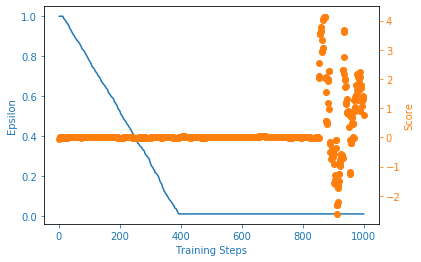

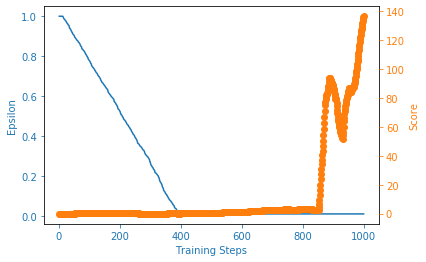

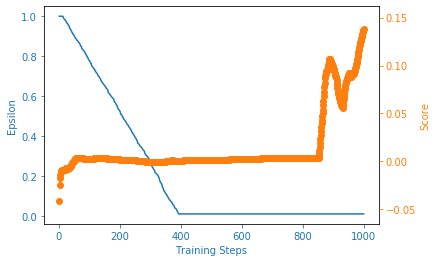

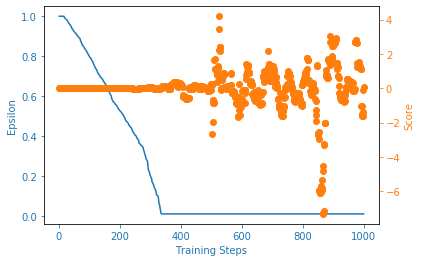

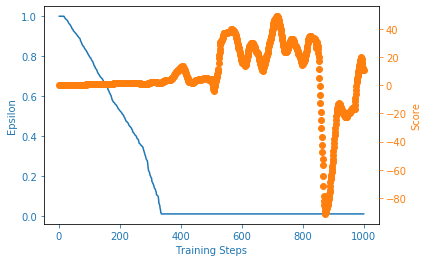

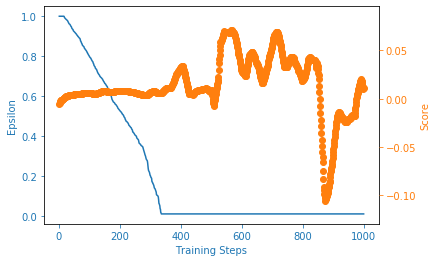

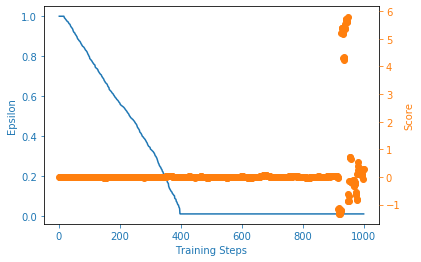

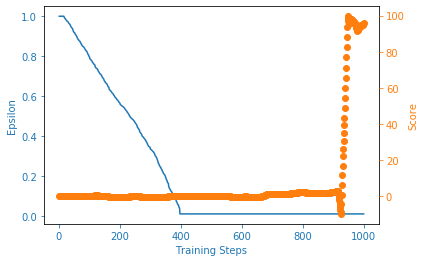

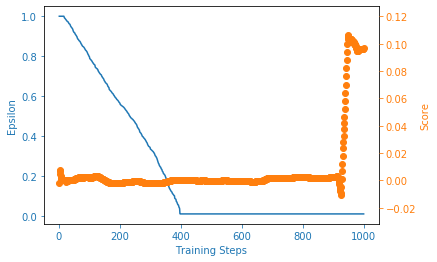

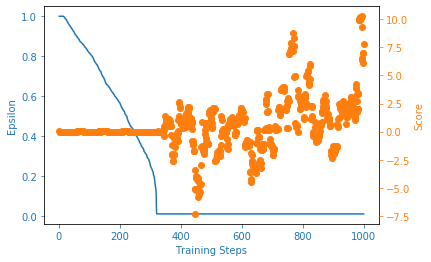

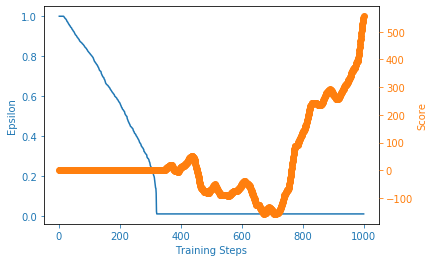

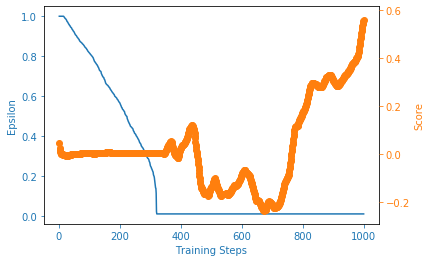

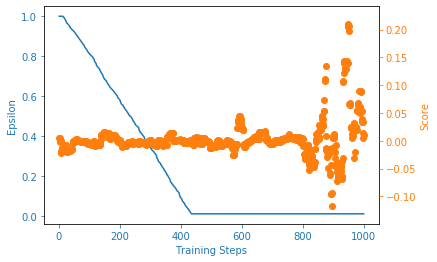

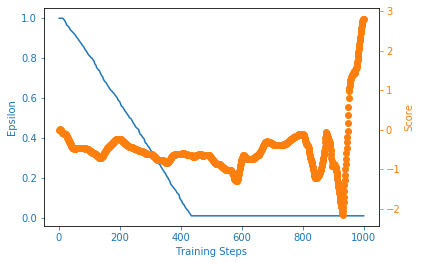

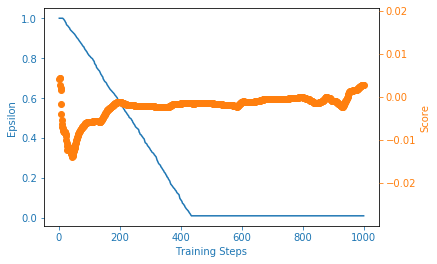

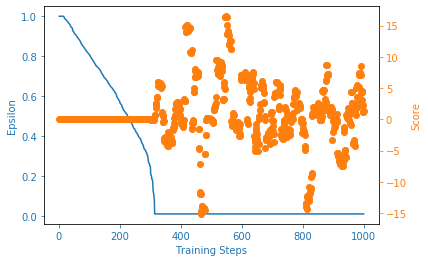

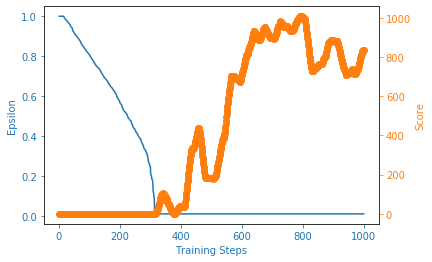

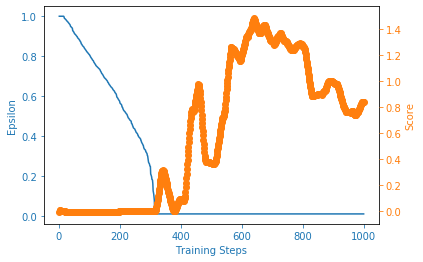

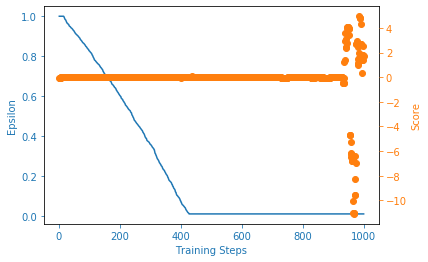

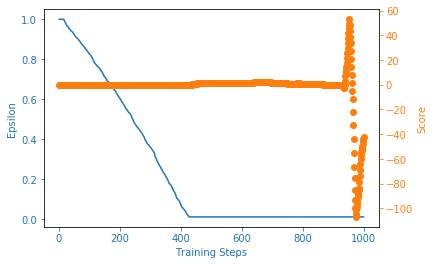

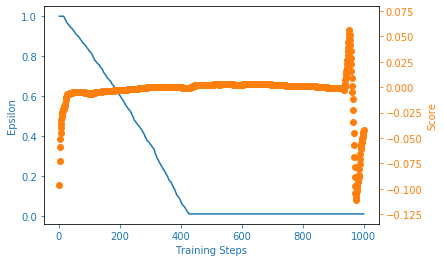

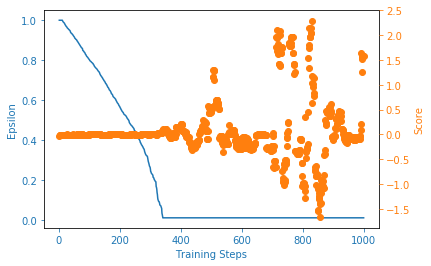

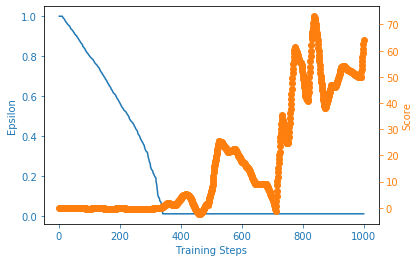

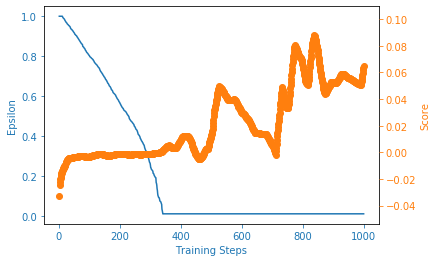

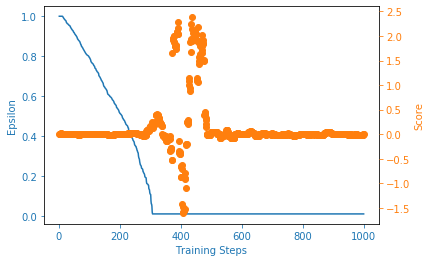

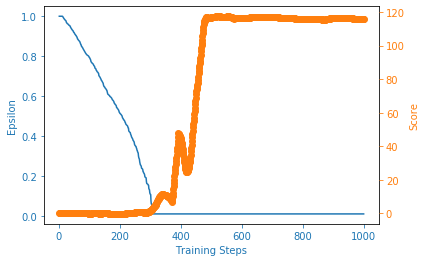

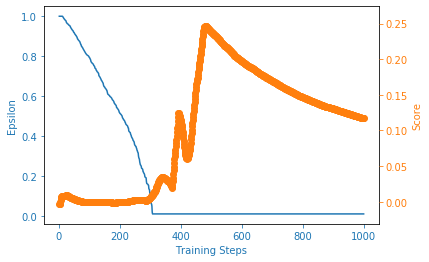

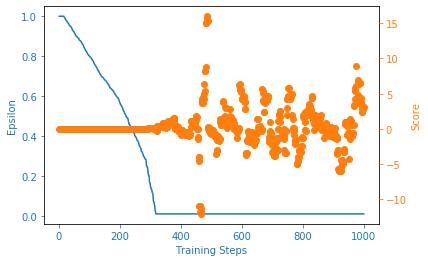

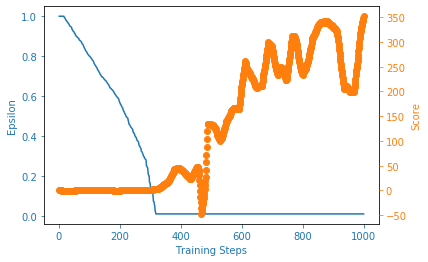

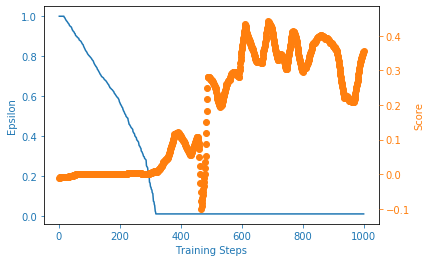

In [11]:
from environment import environment

historical_data = pd.read_csv(r'C:\Users\ratatosck\Desktop\pythonScripts\TradeBot\HistoricalData\EURUSD15.csv', sep='\t',header=None)
historical_data.drop(0, axis=1, inplace = True)
historical_data_np = historical_data.to_numpy(dtype = 'float32')

### hyperparameters
observation_size = 30

# env = environment(historical_data_np, observation_size)

# agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size=64, n_actions = 3, 
#              eps_end = 0.01, input_dims1 = [observation_size, 5], input_dims2 = [2], lr=0.001)

###
scores, eps_history, all_scores_sum, all_scores_average = [], [], [], []
n_games = 1000
n_run = 10


# the nn is not reseting on new run, youll have to decide if this is a good or bad thing.

# also changing the graph to use the sum of scores (overall profit) after each episode, instead of individual scores for 
# each episode might be more clear as a metric for performance.

for j in range(n_run):
    scores = []
    sum_scores = []
    avg_scores = []
    eps_history = []
    
    env = environment(historical_data_np, observation_size)
    agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size=64, n_actions = 3, 
             eps_end = 0.01, input_dims1 = [observation_size, 5], input_dims2 = [2], lr=0.001)
    
    for i in range (n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

#         avg_score = np.mean(scores[-100:])
        avg_score = np.mean(scores)
        sum_score = np.sum(scores)
        avg_scores.append(avg_score)
        sum_scores.append(sum_score)

        print('episode', i, 'score %.2f' % score, 
                 'average score %.2f' % avg_score,
                 'sum score %.2f' % sum_score,
                 'epsilon %.2f'% agent.epsilon)
        
    all_scores_sum.append(sum(scores))
    all_scores_average.append(sum(scores)/len(scores))
        
    x = [i+1 for i in range(n_games)]
    # filename = 'results-v2'
    

    filename1 = 'plots/score-graph-' + str(j+1)
    filename2 = 'plots/sum-graph-' + str(j+1)
    filename3 = 'plots/average-graph-' + str(j+1)
    plot_learning_curve(x, scores, eps_history, filename1)
    plot_learning_curve(x, sum_scores, eps_history, filename2)
    plot_learning_curve(x, avg_scores, eps_history, filename3)

In [12]:
print("all_scores_sum")
print(all_scores_sum)
print("all_scores_average")
print(all_scores_average)


all_scores_sum
[142.50312328338623, 10.277478694915771, 95.39838194847107, 575.3482830524445, 2.6060569286346436, 846.4772915840149, -13.758081197738647, 83.10495138168335, 115.80050230026245, 359.78622794151306]
all_scores_average
[0.14250312328338624, 0.010277478694915772, 0.09539838194847107, 0.5753482830524445, 0.0026060569286346434, 0.8464772915840149, -0.013758081197738647, 0.08310495138168335, 0.11580050230026245, 0.35978622794151305]


There are a couple of problems right now. first, the training is'nt stable. This might be due to many things, there could be some catastrophic forgetting happening here, or it might just be the limit of the vanilla dqn, or it might just be that the environment is too random, or that the reward function is not good enough, maybe a bit of hyperparameter tuning might be good enough to solve the problem.

There are a lot of questions that remain from this implementation: is the experience replay working? is the pipeline working? does the environment work? this will take a while to figure out.

concerning the reward function, maybe giving negative reward when the agent is on the negative on a trade is good, enforcing early stopping through the reward function might be a good idea. 

also remember that as of now the reward scale is bound to increase as the portfolio increases, so you have to refactor it so that it is based not on profit but on percent return on investment.

other solutions might involve implementing the target network, hyperparameter tuning; like the observation size, the replay memory size, the neural network size/ arquitecture, etc.

however, there is no doubt that im going to have to try other algorithms.

*I did the sum of the scores, and it seems that it ends up positive. this is an indicator that the algorithm might actually be working? I'll have to test and average over multiple runs to see if this is actually the case. thought this brings up an interesting question, I sort of expected the shape of the graph to be trending towards positive, but now that I think about it it seems obvious that it might never be the case, and it's not necessarily a bad thing, you cant expect the algorithm to have a positive trade every time, just like with people, it is normal to have bad trades, but its the average return that determines if the trader is proficient or not. And just like this, you cant expect an algorithm to always have positive returns. in conclusion, the metric for success is not only the shape of the graph, but the overall return from the whole training procedure; by doing the sum of all the scores "sum(scores)" and the higher the number  the better, and then doing an average over multiple training loops.

*There is another idea that has to be investigated, should the agent be always "greedy" when deployed to production or should you always have a non zero epsilon? and should the agent still have a learning call or should you stop learning when the agent is deployed?

*And finally the question of transfer learning, will it be possible? the training environment would have to be very close to the actual production environment for it to work. unless I come up with some revolutionary way to do transfer learning in rl (not likely).

*another interesting idea might be to implement a sort of dual experience replay, that being 2 replay buffers, one for positive rewards and one for negative rewards and then sample from them equally. this might help with catastrophic forgetting.